<h1>Standards</h1>

Trying to find all the peaks in the standard list and plotting their motifs..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project time taken = 20.8671839237
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/30/15 16:11:30
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [3]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Load the motifs of interest from an external file

In [4]:
import csv
motif_annotation = {}
motif_idx = {}
i = 0
for item in csv.reader(open("results/beer3pos_annotation_Nov2015.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + "\t" + val
    motif_annotation[key] = val
    motif_idx[key] = i
    i += 1

motifs_of_interest = motif_annotation.keys()    

# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

2	Small nitrogen containing fragment ion - often proline or ornithine derived
260	Water loss - indicative of a free hydroxyl group
262	Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
226	Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
158	Leucine substructure
243	Conjugation of a phosphate group (H4O4P) substructure
127	Conjugation of a phosphate group (H4O4P) substructure
53	Losses indicative of a hexose with NH2 group
98	Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
174	Pyroglutamic acid (pyroglutamate) substructure
59	Pyroglutamic acid (pyroglutamate) substructure
214	Amine loss - suggests free NH2 group in fragmented molecule
60	Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
151	[proline-H2O] suggests conjugated proline substructure
280	Loss possibly indicative of carboxylic acid group with 1-carbon attac

In [5]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 256 motifs from the graph because they're not in the list
Removed [] from the graph because they don't share documents with other motifs in the list
Removed 367 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 1099
Number of edges: 1708
Average degree:   3.1083


How many MS1 peaks can be explained by the M2Ms in the validated list?

In [6]:
ms1_count = 0
nodes = G.nodes(data=True)
for node_id, node_data in nodes:
    # 1 for doc, 2 for motif
    if node_data['group'] == 1: 
        ms1_count += 1
        
print "%d (out of %d) MS1 peaks found in the graph" % (ms1_count, ms2lda.ms1.shape[0])

1055 (out of 1422) MS1 peaks found in the graph


<h2>3. Standard Peaks</h2>

Now we need to find which MS1 peaks match the list of standards. First, load the standard csv.

In [7]:
mode = 'POS' # either 'POS' or 'NEG'

std_peaks = []
with open("results/StandardsCombined_20150422_forJoe.csv", "rb") as infile:
   reader = csv.reader(infile)
   next(reader, None)  # skip the headers
   for row in reader:
    stdmix = int(row[0])
    compound_name = row[1]
    formula = row[2]
    polarity = row[3]
    mz = float(row[4])
    rt = float(row[5]) * 60
    mh_intensity = float(row[6])
    tup = (stdmix, compound_name, formula, polarity, mz, rt, mh_intensity)
    if mode == 'POS' and polarity == '+':
        std_peaks.append(tup)
    elif mode == 'NEG' and polarity == '-':
        std_peaks.append(tup)

for tup in std_peaks:
    print tup

(1, '1-Naphthylacetic acid', 'C12H10O2', '+', 187.07535, 249.60000000000002, 54057.0)
(1, 'Serotonin', 'C10H12N2O', '+', 177.10242, 259.20000000000005, 97472.0)
(1, 'Melatonin', 'C13H16N2O2', '+', 233.12831, 276.0, 642246756.0)
(1, 'Phenylhydrazine', 'C6H8N2', '+', 109.07608, 301.8, 5947432.0)
(1, 'Nicotinate', 'C6H5NO2', '+', 124.03932, 412.2, 761863744.0)
(1, 'Pyridoxine', 'C8H11NO3', '+', 170.0811, 435.59999999999997, 1744299213.0)
(1, 'riboflavin', 'C17H20N4O6', '+', 377.14548, 452.4, 9255138.0)
(1, 'Glycerol', 'C3H8O3', '+', 93.05468, 480.0, 2873527.0)
(1, 'Adenine', 'C5H5N5', '+', 136.06174, 491.99999999999994, 167402201.0)
(1, 'Creatinine', 'C4H7N3O', '+', 114.06613, 496.79999999999995, 1055015474.0)
(1, 'L-Phenylalanine', 'C9H11NO2', '+', 166.0862, 499.8, 54983812.0)
(1, 'L-Leucine', 'C6H13NO2', '+', 132.10185, 520.8, 178751219.0)
(1, '4-Aminobenzoate', 'C7H7NO2', '+', 138.05498, 511.2, 21075822.0)
(1, 'Inosine', 'C10H12N4O5', '+', 269.08783, 528.0, 59555340.0)
(1, '2-Phenylgly

Find out the peak ids in our MS1 dataframe that match these standards

In [8]:
import math

mass_tol = 3
rt_tol = 12

std = np.array(std_peaks)
std_mz = np.array([x[4] for x in std_peaks])
std_rt = np.array([x[5] for x in std_peaks])
matches = {}

ms1_label = {}
for row in ms2lda.ms1.itertuples(index=True):
    peakid = row[1]
    mz = row[5]
    rt = row[4]

    # the following line is hacky for pos mode data
    mass_delta = mz*mass_tol*1e-6
    mass_start = mz-mass_delta
    mass_end = mz+mass_delta
    rt_start = rt-rt_tol
    rt_end = rt+rt_tol

    match_mass = (std_mz>mass_start) & (std_mz<mass_end)
    match_rt = (std_rt>rt_start) & (std_rt<rt_end)
    match = match_mass & match_rt

    res = std[match]
    if len(res) == 1:
        closest = tuple(res[0])
        matches[closest] = row
        ms1_label[row[1]] = closest[1]        
    elif len(res)>1:
        closest = None
        min_dist = sys.maxint
        for match_res in res:
            match_mz = float(match_res[4])
            match_rt = float(match_res[5])
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res
        closest = tuple(closest)
        matches[closest] = row
        ms1_label[row[1]] = closest[1]

print "Matches found %d/%d" % (len(matches), len(std))
print

ms1_list = []
for match in matches:
    key = str(match)
    ms1_row = matches[match]
    value = str(ms1_row)
    pid = ms1_row[1]
    print "Standard %s" % key
    print "MS1 %s" % value
    print
    ms1_list.append(pid)

Matches found 45/117

Standard ('3', 'O-Acetylcarnitine', 'C9H17NO4', '+', '204.12289', '520.2', '2530268729.0')
MS1 (10237, 10237, 0, 1, 518.50300000000004, 204.12305134669299, 2407559.25, 1, 0, 0, 'C9H18O4N')

Standard ('2', 'L-homoserine', 'C4H9NO3', '+', '120.06561', '637.8', '91565828.0')
MS1 (1003, 1003, 0, 1, 633.80399999999997, 120.065513905275, 5077896.0, 1, 0, 0, 'C4H10O3N')

Standard ('2', '5-Oxoproline', 'C5H7NO3', '+', '130.04996', '491.4', '210756304.0')
MS1 (1795, 1795, 0, 1, 484.00199999999995, 130.04989405333401, 247324512.0, 1, 0, 0, 'C5H8O3N')

Standard ('3', 'O-Acetyl-L-serine', 'C5H9NO4', '+', '148.06027', '586.8', '34229806.0')
MS1 (3970, 3970, 0, 1, 598.46900000000005, 148.06034209730601, 6657020.0, 1, 0, 0, 'C5H10O4N')

Standard ('1', 'Pyridoxine', 'C8H11NO3', '+', '170.0811', '435.6', '1744299213.0')
MS1 (6289, 6289, 0, 1, 433.34899999999999, 170.08113568683601, 38320380.0, 1, 0, 0, 'C8H12O3N')

Standard ('2', 'N(pi)-Methyl-L-histidine', 'C7H11N3O2', '+', '170.

MS1 peakID 10237 mz 204.1231 rt 518.50 intensity 2407559.25 (C9H18O4N; O-Acetylcarnitine)
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),



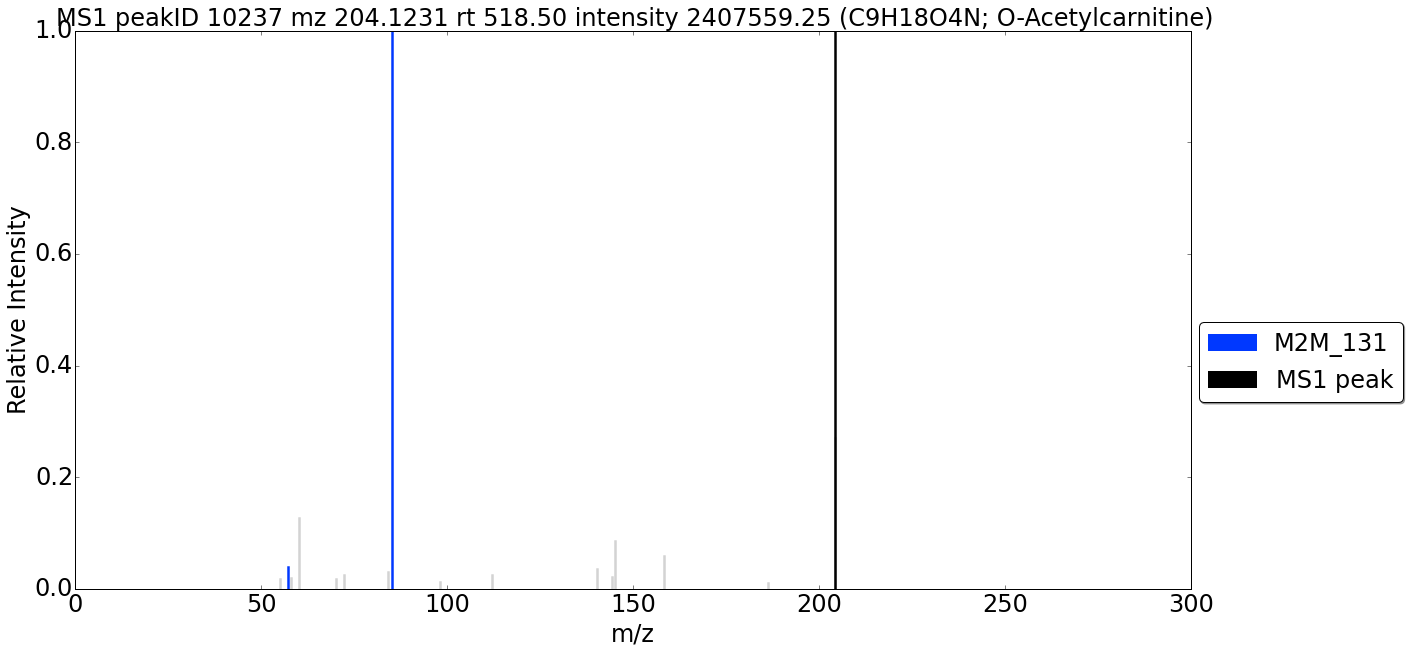

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,85.028305,1.000000,fragment_85.02832,131,loss_119.09448,NaN,"C4H5O2,loss_C5H13O2N"
1,204.124115,0.269851,fragment_204.12411,NaN,NaN,NaN,C10H14N5
2,60.081009,0.126211,fragment_60.08102,NaN,loss_144.04202,NaN,"C3H10N,loss_C6H8O4"
3,145.049988,0.084996,fragment_145.04997,NaN,loss_59.07313,NaN,"C6H9O4,loss_C3H9N"
4,158.080551,0.059581,fragment_158.08046,NaN,NaN,NaN,C7H12O3N
5,57.033707,0.038970,fragment_57.0337,131,loss_147.08937,NaN,"C3H5O,loss_C6H13O3N"
6,140.070328,0.036045,fragment_140.07024,NaN,loss_64.05223,NaN,C7H10O2N
7,84.080688,0.029436,fragment_84.08071,NaN,loss_120.04228,NaN,"C5H10N,loss_C4H8O4"
8,112.075859,0.025067,fragment_112.07584,NaN,loss_92.04711,NaN,"C6H10ON,loss_C3H8O3"
9,72.080780,0.024387,fragment_72.0807,NaN,loss_132.04207,NaN,"C4H10N,loss_C5H8O4"


MS1 peakID 1003 mz 120.0655 rt 633.80 intensity 5077896.00 (C4H10O3N; L-homoserine)
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



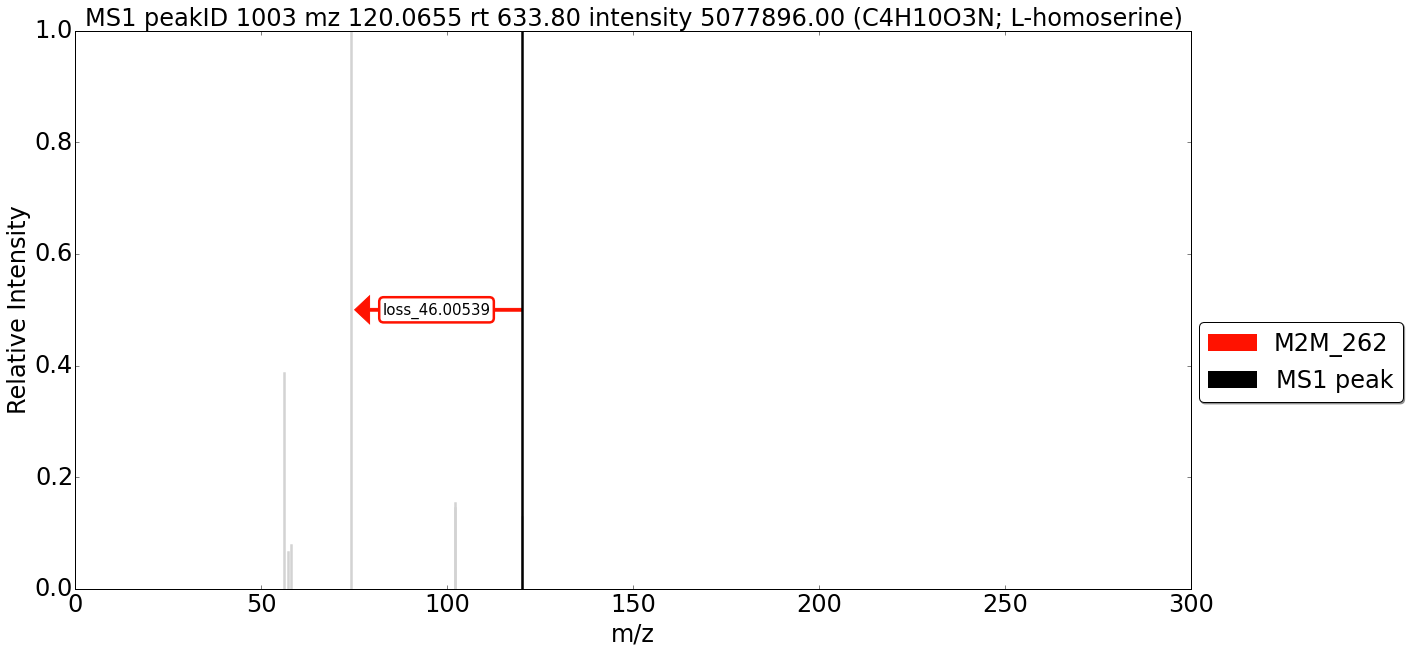

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,74.060349,1.000000,fragment_74.06031,None,loss_46.00539,262,"C3H8ON,loss_CH2O2"
1,56.049747,0.386553,fragment_56.04977,None,loss_64.01595,NaN,C3H6N
2,102.091774,0.154149,fragment_102.09182,None,loss_17.97339,NaN,C5H12ON
3,102.054504,0.144799,fragment_102.0547,None,loss_18.00923,NaN,C4H8O2N
4,120.101738,0.129224,fragment_120.1017,None,NaN,NaN,C5H14O2N
5,58.065491,0.079124,fragment_58.06552,None,loss_62.00034,NaN,C3H8N
6,57.034039,0.065922,fragment_57.0337,None,loss_63.03191,NaN,"C3H5O,loss_CH5O2N"


MS1 peakID 1795 mz 130.0499 rt 484.00 intensity 247324512.00 (C5H8O3N; 5-Oxoproline)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



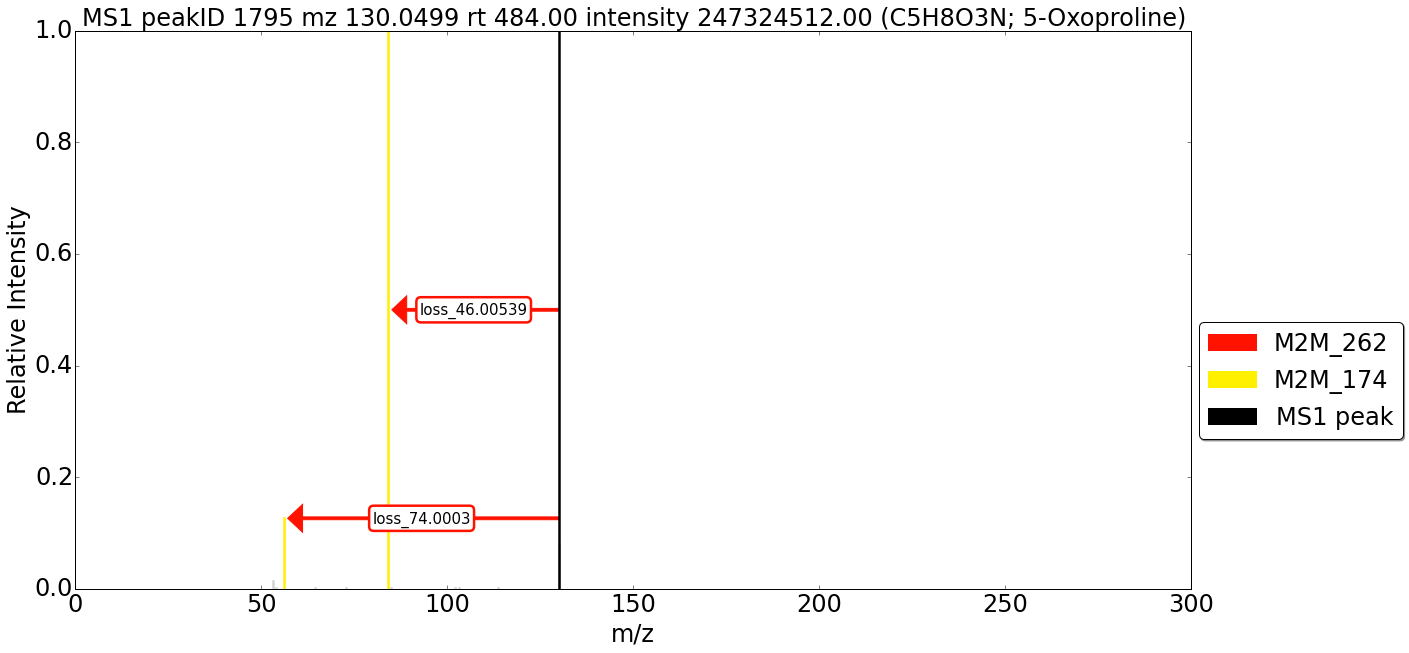

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,84.044189,1.000000,fragment_84.0442,174,loss_46.00539,262,"C4H6ON,loss_CH2O2"
1,56.049809,0.126340,fragment_56.04977,174,loss_74.0003,262,"C3H6N,loss_C2H2O3"
2,130.050613,0.080313,fragment_130.05051,NaN,NaN,NaN,C5H8O3N
3,53.002689,0.014785,fragment_53.00259,NaN,loss_77.04757,NaN,"C3HO,loss_C2H7O2N"
4,102.055672,0.002177,fragment_102.05568,NaN,loss_27.99401,NaN,NaN
5,84.896111,0.001458,fragment_84.89611,NaN,NaN,NaN,NaN
6,72.818222,0.001417,fragment_72.81822,NaN,NaN,NaN,NaN
7,64.463036,0.001337,fragment_64.46304,NaN,NaN,NaN,NaN
8,113.690063,0.001295,fragment_113.69006,NaN,NaN,NaN,NaN
9,103.106133,0.001274,fragment_103.10613,NaN,NaN,NaN,NaN


MS1 peakID 3970 mz 148.0603 rt 598.47 intensity 6657020.00 (C5H10O4N; O-Acetyl-L-serine)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),



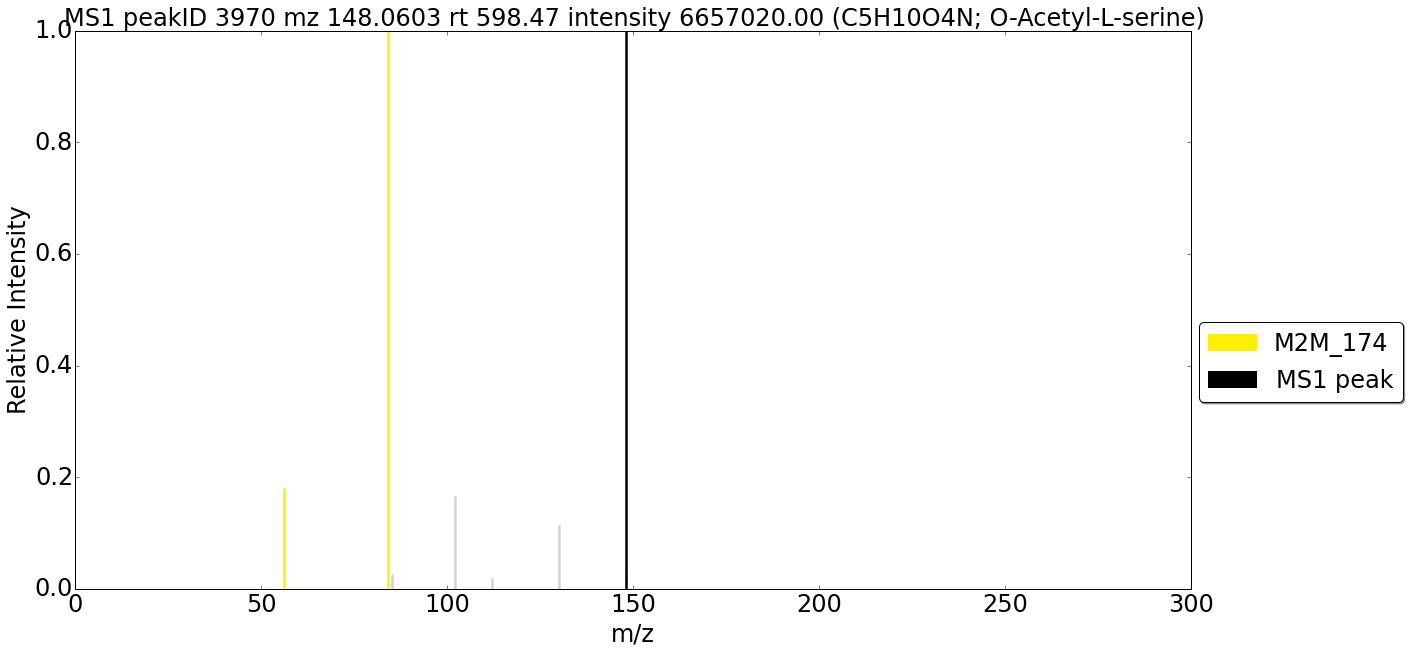

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,84.044144,1.000000,fragment_84.0442,174,loss_64.01595,NaN,C4H6ON
1,56.049824,0.178829,fragment_56.04977,174,loss_92.01076,NaN,"C3H6N,loss_C2H4O4"
2,102.054649,0.164297,fragment_102.0547,NaN,loss_46.00539,NaN,"C4H8O2N,loss_CH2O2"
3,130.050461,0.112925,fragment_130.05051,NaN,loss_18.00923,NaN,C5H8O3N
4,85.028168,0.023997,fragment_85.02832,NaN,loss_63.03191,NaN,"C4H5O2,loss_CH5O2N"
5,148.060303,0.023909,fragment_148.06033,NaN,NaN,NaN,C5H10O4N
6,112.075813,0.017748,fragment_112.07584,NaN,loss_35.9844,NaN,C6H10ON


MS1 peakID 6289 mz 170.0811 rt 433.35 intensity 38320380.00 (C8H12O3N; Pyridoxine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_60	: Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
		  loss_36.01851 (0.913),



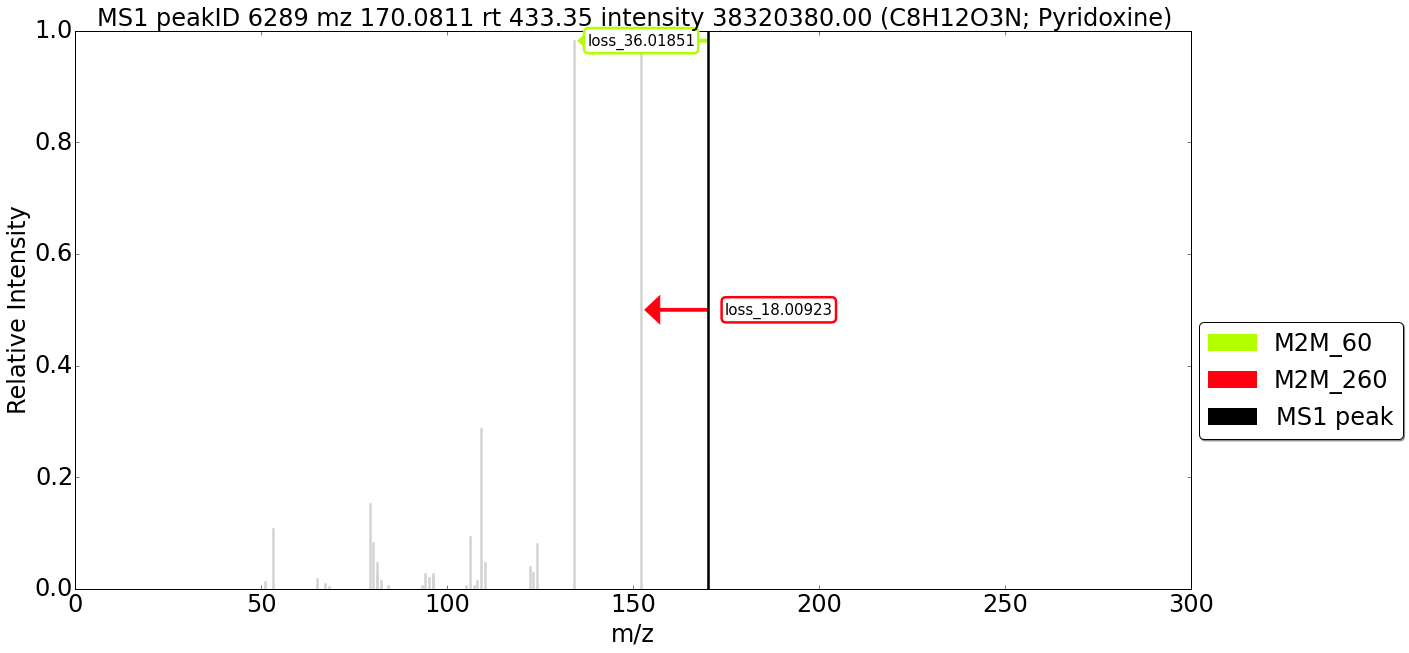

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,152.070267,1.000000,fragment_152.07028,None,loss_18.00923,260,C2H11ON5P
1,134.060013,0.982310,fragment_134.06003,None,loss_36.01851,60,C8H8ON
2,109.052605,0.287127,fragment_109.05264,None,loss_61.02852,NaN,C2H10ON2P
3,170.081390,0.222130,fragment_170.0813,None,NaN,NaN,C8H12O3N
4,79.054184,0.152112,fragment_79.05416,None,loss_91.0268,NaN,"C6H7,loss_C2H5O3N"
5,53.038906,0.107635,fragment_53.03888,None,loss_117.04227,NaN,"C4H5,loss_C4H7O3N"
6,106.064941,0.093034,fragment_106.06503,None,loss_64.01595,NaN,C7H8N
7,80.049446,0.081468,fragment_80.04949,None,loss_90.03155,NaN,"C5H6N,loss_C3H6O3"
8,124.075218,0.080897,fragment_124.07522,None,loss_46.00539,NaN,"C7H10ON,loss_CH2O2"
9,110.059799,0.046957,fragment_110.05978,None,loss_60.02094,NaN,"C6H8ON,loss_C2H4O2"


MS1 peakID 6319 mz 170.0924 rt 558.50 intensity 3766961.75 (C7H12O2N3; N(pi)-Methyl-L-histidine)
 - M2M_40	: Imidazole group linked to a carboxylgroup through one CH2 group substructure
		  fragment_83.06041 (0.433),fragment_129.06581 (0.130),fragment_56.04977 (0.073),fragment_230.15978 (0.045),loss_132.09749 (0.022),fragment_257.12534 (0.012),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



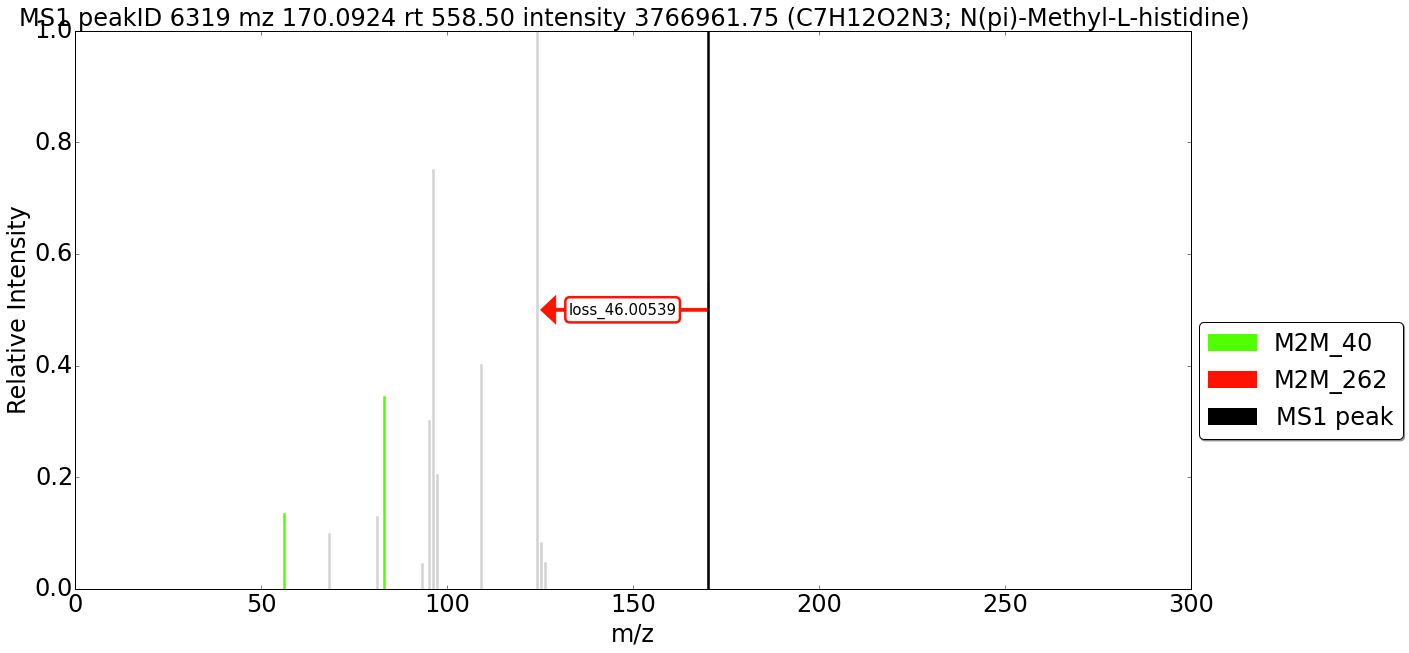

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,124.087044,1.000000,fragment_124.08698,NaN,loss_46.00539,262,"C6H10N3,loss_CH2O2"
1,96.068291,0.749972,fragment_96.06827,NaN,loss_74.02423,NaN,NaN
2,170.091705,0.548146,fragment_170.09171,NaN,NaN,NaN,C7H12O2N3
3,109.076538,0.400958,fragment_109.07636,NaN,loss_61.01619,NaN,"C6H9N2,loss_CH3O2N"
4,83.060471,0.343872,fragment_83.06041,40,loss_87.03196,NaN,"C4H7N2,loss_C3H5O2N"
5,95.060829,0.300049,fragment_95.06076,NaN,loss_75.03184,NaN,"C5H7N2,loss_C2H5O2N"
6,97.076408,0.204232,fragment_97.07643,NaN,loss_73.01611,NaN,"C5H9N2,loss_C2H3O2N"
7,56.049877,0.134257,fragment_56.04977,40,loss_114.04263,NaN,"C3H6N,loss_C4H6O2N2"
8,81.045074,0.128215,fragment_81.04501,NaN,loss_89.04752,NaN,"C4H5N2,loss_C3H7O2N"
9,68.049881,0.097533,fragment_68.04977,NaN,loss_102.04259,NaN,"C4H6N,loss_C3H6O2N2"


MS1 peakID 4121 mz 150.0774 rt 437.17 intensity 15326802.00 (C6H8N5; 6-Methylaminopurine)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 5456 mz 162.1124 rt 582.25 intensity 7117894.00 (C7H16O3N; L-Carnitine)
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)
		  fragment_85.02832 (0.566),fragment_69.03368 (0.105),fragment_97.02839 (0.088),fragment_61.02854 (0.070),fragment_57.0337 (0.045),fragment_91.03925 (0.022),fragment_127.03868 (0.021),fragment_73.0285 (0.019),fragment_55.01824 (0.019),



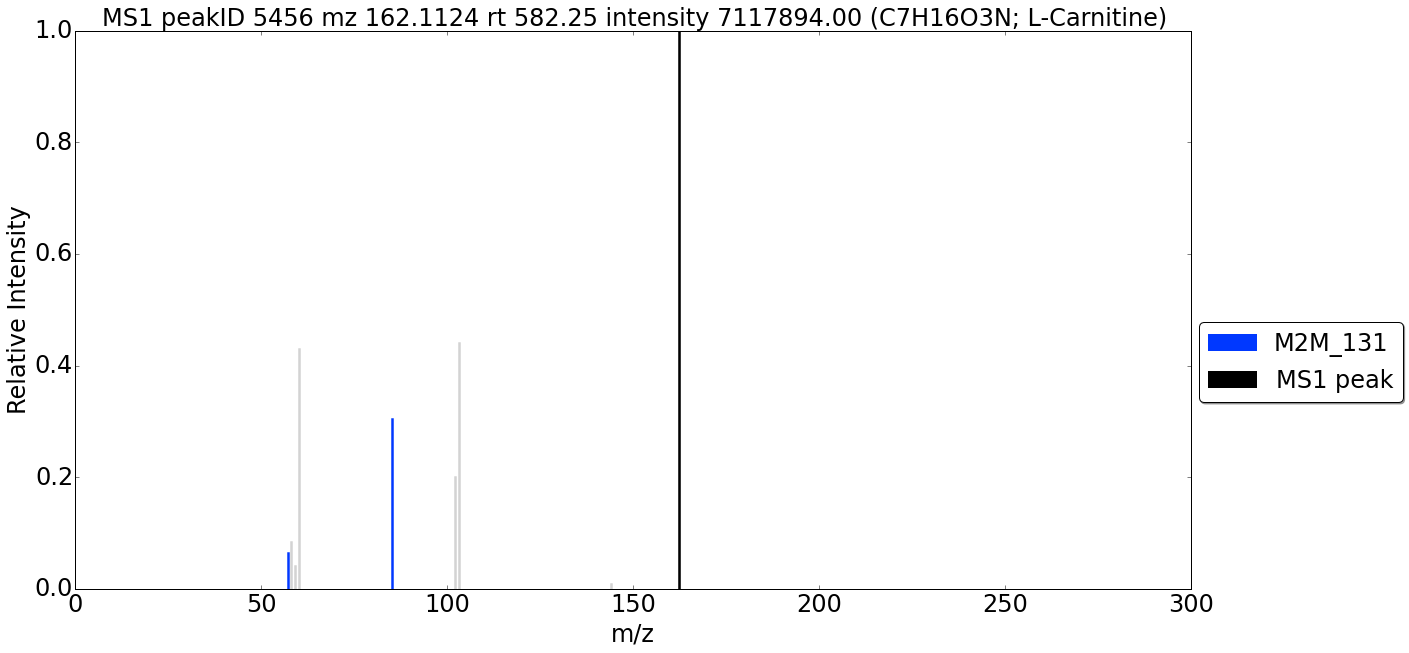

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,162.112808,1.000000,fragment_162.11281,NaN,NaN,NaN,C7H16O3N
1,103.038605,0.439828,fragment_103.03863,NaN,loss_59.07393,NaN,"C4H7O3,loss_C3H9N"
2,60.081043,0.429422,fragment_60.08102,NaN,loss_102.03159,NaN,"C3H10N,loss_C4H6O3"
3,85.028313,0.304272,fragment_85.02832,131,loss_77.08387,NaN,C4H5O2
4,102.091858,0.200151,fragment_102.09182,NaN,loss_60.02094,NaN,"C5H12ON,loss_C2H4O2"
5,58.065536,0.084210,fragment_58.06552,NaN,loss_104.04718,NaN,"C3H8N,loss_C4H8O3"
6,57.033707,0.064344,fragment_57.0337,131,loss_105.07881,NaN,"C3H5O,loss_C4H11O2N"
7,59.073090,0.041019,fragment_59.07323,NaN,loss_103.03876,NaN,loss_C2H5O2N3
8,144.080505,0.007790,fragment_144.08061,NaN,NaN,NaN,C10H10N


MS1 peakID 6001 mz 166.0863 rt 499.24 intensity 15979306.00 (C9H12O2N; L-Phenylalanine)
 - M2M_115	: [phenylalanine-COOH] substructure
		  fragment_120.0804 (0.513),fragment_103.05448 (0.153),fragment_166.08631 (0.070),loss_45.99208 (0.048),fragment_93.06981 (0.020),fragment_91.05413 (0.020),fragment_53.03888 (0.018),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



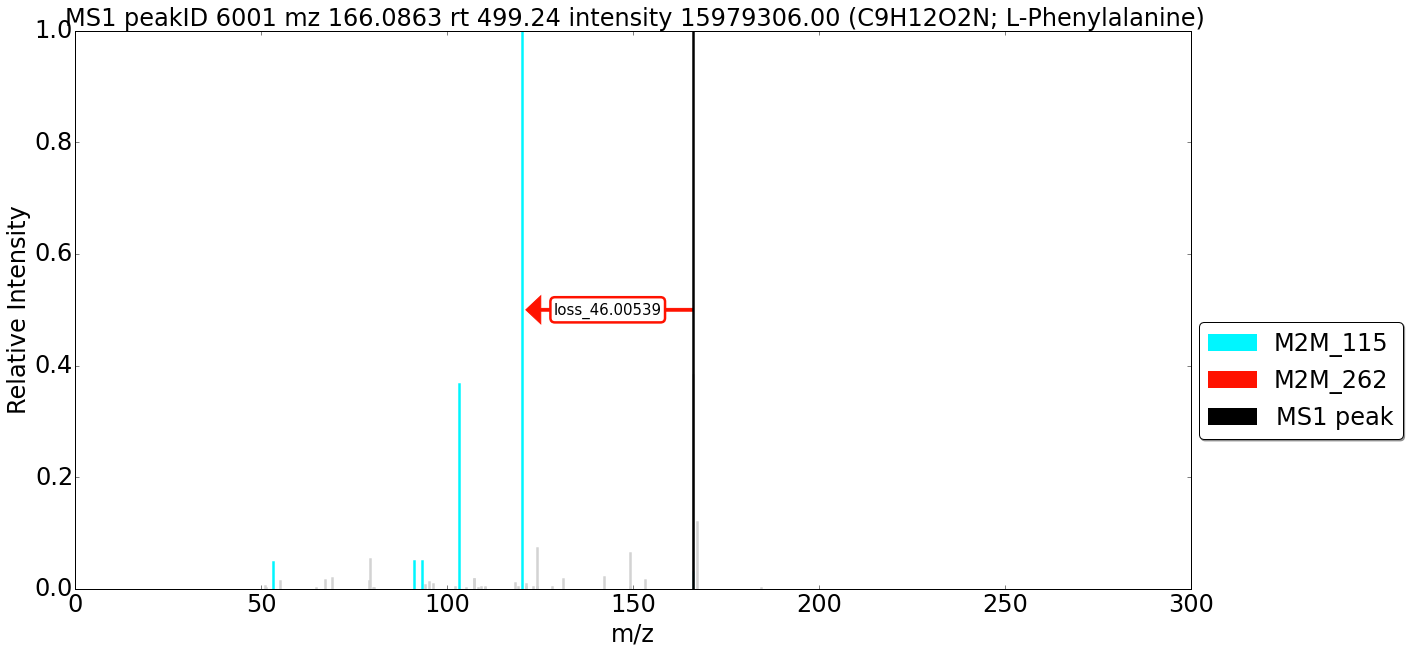

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,120.080345,1.000000,fragment_120.0804,115,loss_46.00539,262,"C8H10N,loss_CH2O2"
1,166.072067,0.382615,fragment_166.07209,NaN,NaN,NaN,C6H16NS2
2,103.054443,0.367646,fragment_103.05448,115,loss_63.03191,NaN,"C8H7,loss_CH5O2N"
3,167.056732,0.118901,fragment_167.05677,NaN,NaN,NaN,C6H7O2N4
4,124.050262,0.073254,fragment_124.05026,NaN,NaN,NaN,C5H6ON3
5,149.045929,0.063575,fragment_149.04599,NaN,loss_17.0403,NaN,C6H13S2
6,79.054192,0.053536,fragment_79.05416,NaN,loss_87.03196,NaN,"C6H7,loss_C3H5O2N"
7,91.054077,0.050550,fragment_91.05413,115,loss_75.03184,NaN,"C7H7,loss_C2H5O2N"
8,93.069763,0.049533,fragment_93.06981,115,loss_73.01611,NaN,"C7H9,loss_C2H3O2N"
9,53.038937,0.048328,fragment_53.03888,115,loss_113.04742,NaN,"C4H5,loss_C5H7O2N"


MS1 peakID 3912 mz 147.1127 rt 933.27 intensity 1298433.75 (C6H15O2N2; L-Lysine)
 - M2M_45	: Pipecolic acid (pipecolate) substructure
		  fragment_84.08071 (0.757),fragment_56.04977 (0.059),fragment_130.08587 (0.059),loss_91.06316 (0.022),fragment_67.05454 (0.015),



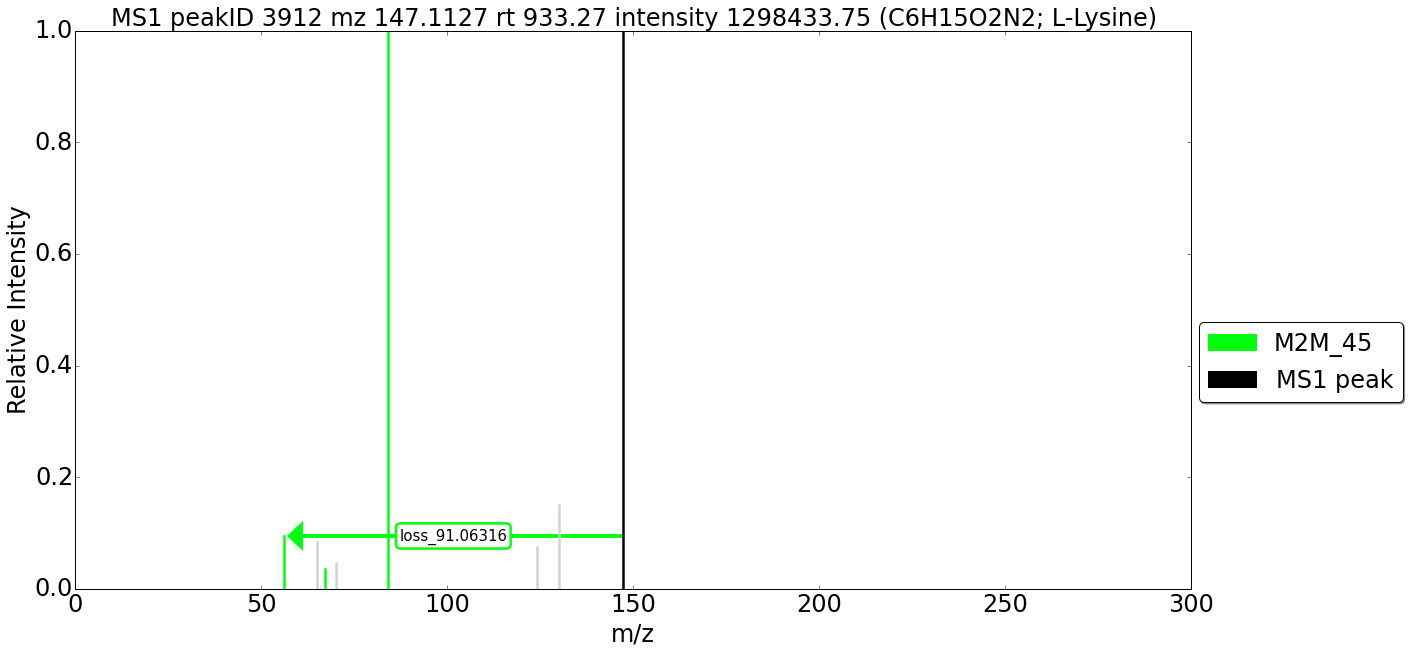

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,84.080612,1.000000,fragment_84.08071,45,loss_63.03191,NaN,"C5H10N,loss_CH5O2N"
1,130.087036,0.150856,fragment_130.08705,NaN,loss_17.02527,NaN,NaN
2,56.049725,0.094670,fragment_56.04977,45,loss_91.06316,45,"C3H6N,loss_C3H9O2N"
3,64.927513,0.083763,fragment_64.92754,NaN,NaN,NaN,NaN
4,123.965050,0.074708,fragment_123.96513,NaN,NaN,NaN,NaN
5,70.065063,0.046102,fragment_70.06514,NaN,loss_77.04757,NaN,"C4H8N,loss_C2H7O2N"
6,67.054482,0.036039,fragment_67.05454,45,NaN,NaN,C5H7


MS1 peakID 2566 mz 134.0447 rt 614.62 intensity 1106318.88 (C4H8O4N; L-Aspartate)
 - M2M_280	: Loss possibly indicative of carboxylic acid group with 1-carbon attached
		  loss_60.02094 (0.741),loss_106.02643 (0.053),fragment_158.11806 (0.052),
 - M2M_42	: Asparagine substructure
		  fragment_74.02353 (0.251),fragment_88.03919 (0.220),fragment_87.05542 (0.078),fragment_133.06148 (0.077),fragment_70.02895 (0.038),fragment_158.04483 (0.034),fragment_60.04477 (0.020),fragment_116.0344 (0.019),loss_101.04757 (0.016),fragment_175.12257 (0.015),loss_188.07979 (0.012),fragment_88.0218 (0.010),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



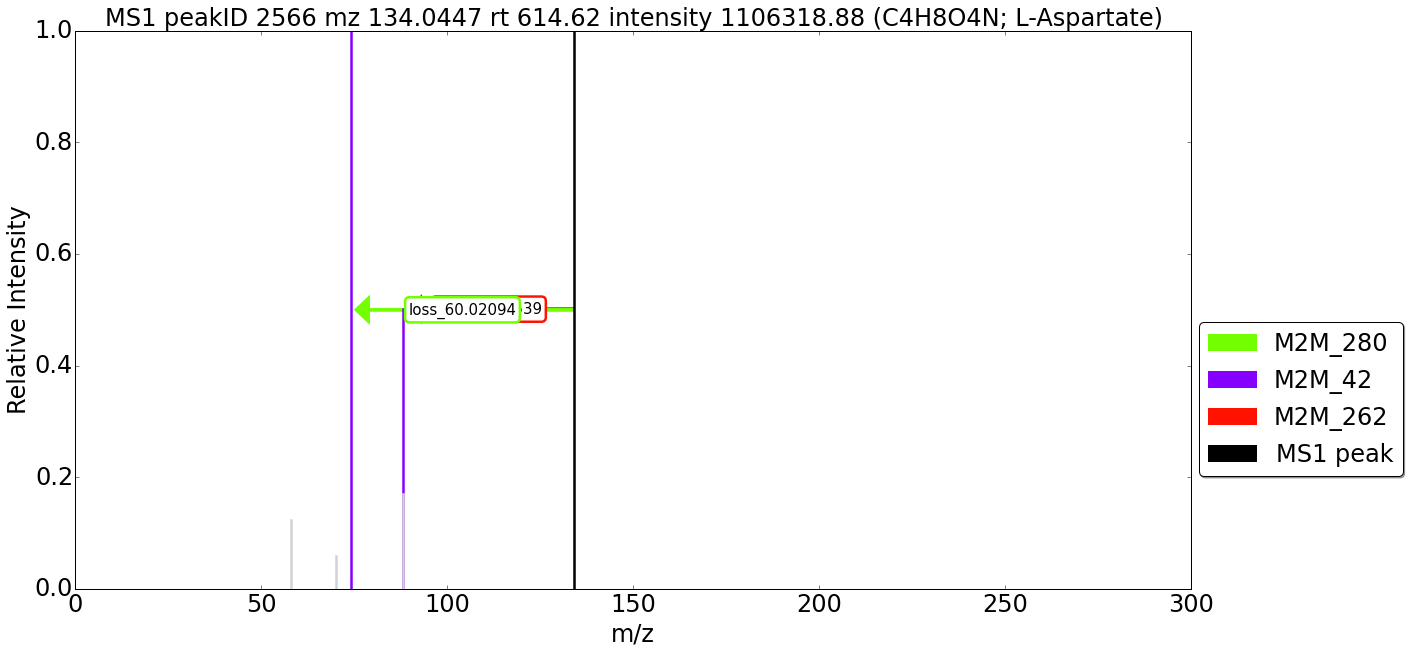

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,74.023651,1.000000,fragment_74.02353,42,loss_60.02094,280,"C2H4O2N,loss_C2H4O2"
1,88.039185,0.501179,fragment_88.03919,42,loss_46.00539,262,"C3H6O2N,loss_CH2O2"
2,88.075974,0.169731,fragment_88.07588,NaN,loss_45.96902,NaN,C4H10ON
3,58.065617,0.124050,fragment_58.06552,NaN,NaN,NaN,C3H8N
4,70.065109,0.059535,fragment_70.06514,NaN,loss_63.97936,NaN,"C4H8N,loss_O4"


MS1 peakID 131 mz 90.0549 rt 645.03 intensity 2888840.50 (C3H8O2N; beta-Alanine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),



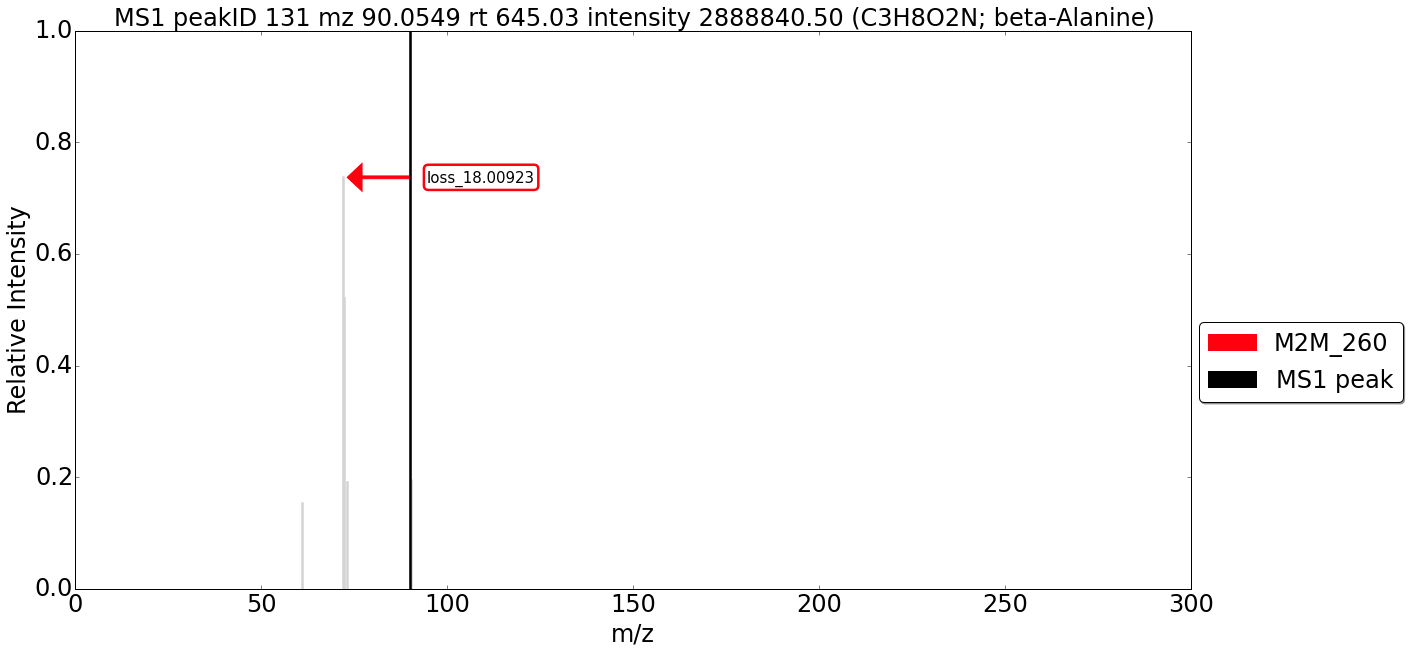

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,90.055382,1.000000,fragment_90.05533,None,NaN,NaN,C3H8O2N
1,72.044762,0.737399,fragment_72.04466,None,loss_18.00923,260,C3H6ON
2,72.080750,0.521527,fragment_72.0807,None,loss_17.97339,NaN,C4H10N
3,90.091835,0.194263,fragment_90.09183,None,NaN,NaN,NaN
4,73.084145,0.191845,fragment_73.08418,None,NaN,NaN,NaN
5,61.028442,0.153448,fragment_61.02854,None,loss_29.02613,NaN,"C2H5O2,loss_CH3N"


MS1 peakID 4307 mz 152.0567 rt 588.46 intensity 165917856.00 (C5H14NS2; Guanine)
 - M2M_162	: Xanthine substructure
		  fragment_152.05609 (0.327),fragment_153.04074 (0.126),loss_115.06303 (0.067),loss_151.04878 (0.045),fragment_110.03458 (0.040),fragment_135.02953 (0.036),loss_116.06671 (0.031),loss_197.05414 (0.020),fragment_128.04551 (0.020),fragment_314.11224 (0.016),loss_114.07908 (0.016),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



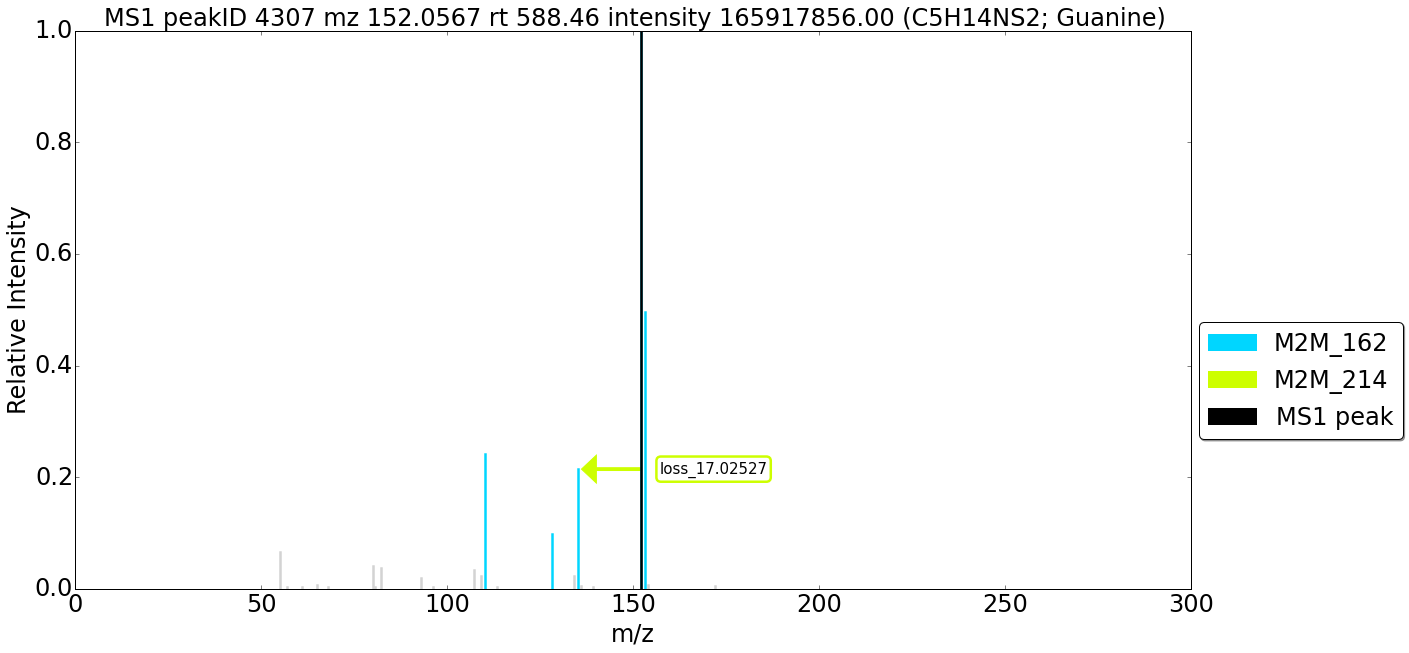

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,152.056046,1.000000,fragment_152.05609,162,NaN,NaN,C4H10O5N
1,153.040680,0.496599,fragment_153.04074,162,NaN,NaN,C5H13OS2
2,110.034615,0.241523,fragment_110.03458,162,loss_42.02193,NaN,"C4H4ON3,loss_CH2N2"
3,135.029663,0.214475,fragment_135.02953,162,loss_17.02527,214,C5H11S2
4,128.045486,0.097583,fragment_128.04551,162,NaN,NaN,C4H6O2N3
5,55.029549,0.065586,fragment_55.02948,NaN,NaN,NaN,C2H3N2
6,80.024315,0.040756,fragment_80.02432,NaN,loss_72.03221,NaN,"C3H2N3,loss_C2H4ON2"
7,82.040253,0.036542,fragment_82.04025,NaN,loss_70.01648,NaN,"C3H4N3,loss_C2H2ON2"
8,107.035301,0.032890,fragment_107.0353,NaN,loss_45.02125,NaN,"C4H3N4,loss_CH3ON"
9,134.046738,0.023744,fragment_134.04671,NaN,loss_18.00923,NaN,C5H4N5


MS1 peakID 7005 mz 175.1189 rt 1002.67 intensity 42606024.00 (C6H15O2N4; L-Arginine)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_151	: [proline-H2O] suggests conjugated proline substructure
		  fragment_116.07116 (0.473),loss_143.05783 (0.166),loss_161.06841 (0.128),loss_115.06303 (0.101),



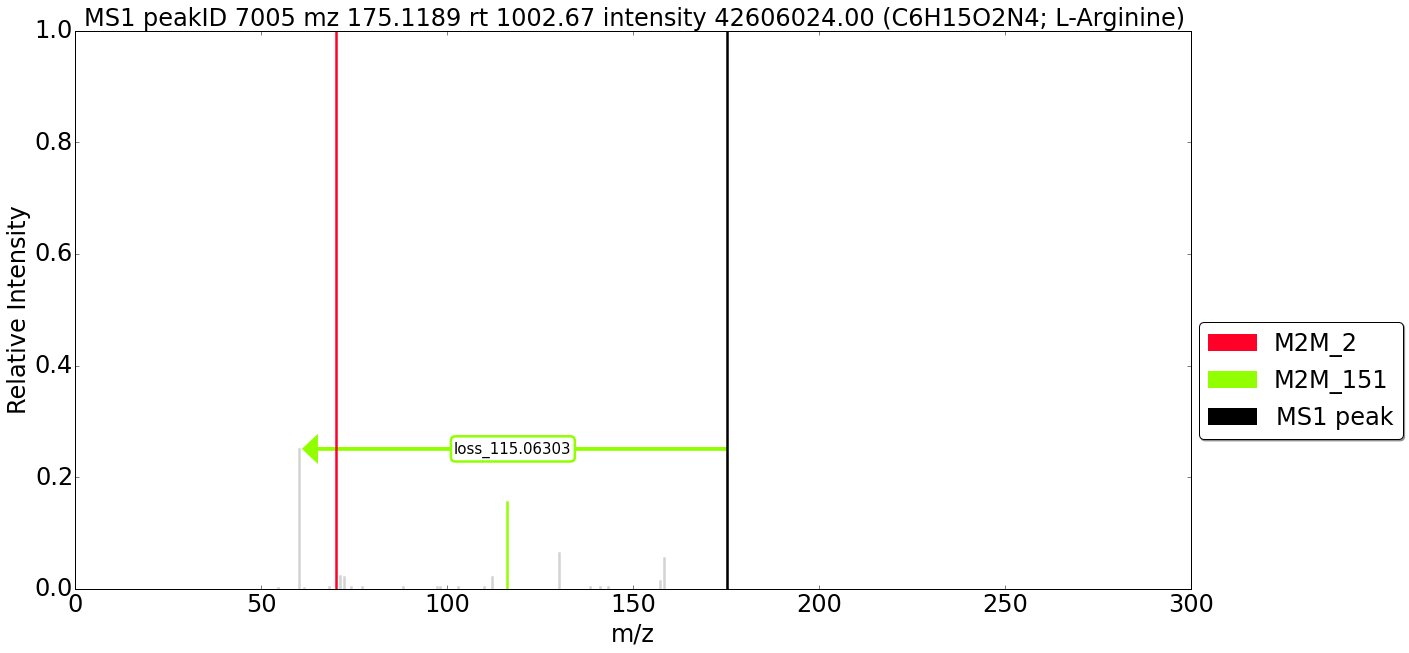

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,70.065071,1.000000,fragment_70.06514,2,loss_105.0541,NaN,"C4H8N,loss_C2H7O2N3"
1,60.055779,0.250707,fragment_60.05587,NaN,loss_115.06303,151,"CH6N3,loss_C5H9O2N"
2,175.119873,0.240603,fragment_175.12007,NaN,NaN,NaN,NaN
3,116.071106,0.154991,fragment_116.07116,151,loss_59.04824,NaN,"C5H10O2N,loss_CH5N3"
4,130.096909,0.064236,fragment_130.09701,NaN,loss_45.02195,NaN,C5H12ON3
5,158.091492,0.054776,fragment_158.09177,NaN,loss_17.02527,NaN,C6H12O2N3
6,71.049438,0.022285,fragment_71.04937,NaN,NaN,NaN,C4H7O
7,72.080750,0.021085,fragment_72.0807,NaN,loss_103.03876,NaN,"C4H10N,loss_C2H5O2N3"
8,112.087013,0.020357,fragment_112.08704,NaN,loss_63.03191,NaN,"C5H10N3,loss_CH5O2N"
9,157.108337,0.014321,fragment_157.10838,NaN,loss_18.00923,NaN,C6H13ON4


MS1 peakID 10364 mz 205.0972 rt 553.53 intensity 36771424.00 (C11H13O2N2; L-Tryptophan)
 - M2M_202	: Tryptophan related substructure
		  fragment_118.06544 (0.155),fragment_146.05935 (0.129),fragment_188.07061 (0.106),fragment_130.06468 (0.061),fragment_91.05413 (0.049),fragment_146.06086 (0.046),fragment_115.05435 (0.045),fragment_144.08061 (0.034),fragment_143.07379 (0.033),fragment_117.05719 (0.032),fragment_261.09335 (0.027),fragment_170.06037 (0.026),fragment_132.08143 (0.023),fragment_128.04963 (0.018),fragment_142.06476 (0.014),
 - M2M_211	: N-acetylputrescine substructure
		  loss_59.037 (0.567),fragment_114.09123 (0.097),loss_101.04757 (0.042),loss_59.00065 (0.030),fragment_131.11777 (0.029),fragment_425.1355 (0.029),fragment_72.04466 (0.023),fragment_60.04477 (0.014),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



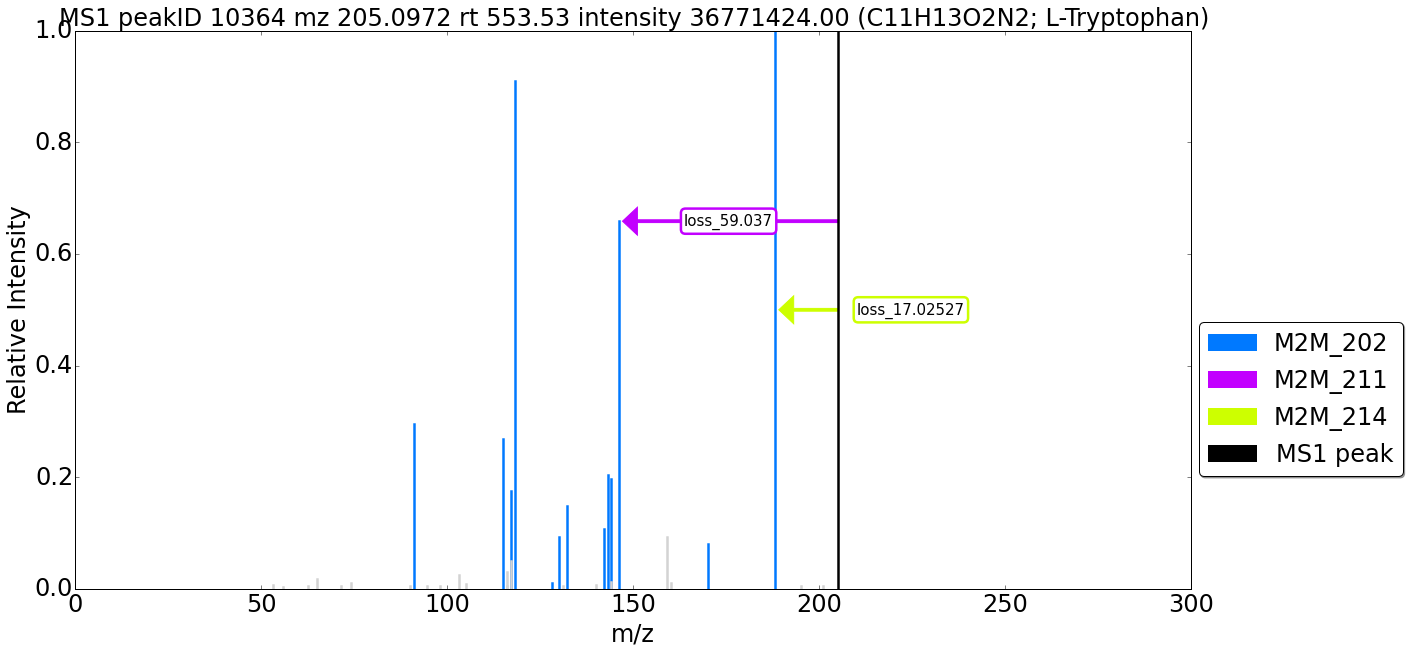

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,188.070572,1.000000,fragment_188.07061,202,loss_17.02527,214,C11H10O2N
1,118.065468,0.910780,fragment_118.06544,202,loss_87.03196,NaN,"C8H8N,loss_C3H5O2N"
2,146.059402,0.658810,fragment_146.05935,202,loss_59.037,211,"C3H9N5P,loss_C2H5ON"
3,91.054146,0.296194,fragment_91.05413,202,loss_114.04263,NaN,"C7H7,loss_C4H6O2N2"
4,115.054367,0.268003,fragment_115.05435,202,loss_90.04283,NaN,"C9H7,loss_C2H6O2N2"
5,143.073792,0.204197,fragment_143.07379,202,NaN,NaN,C6H12N2P
6,144.080597,0.196105,fragment_144.08061,202,loss_61.01619,NaN,"C10H10N,loss_CH3O2N"
7,117.057220,0.174524,fragment_117.05719,202,NaN,NaN,C4H10N2P
8,132.081421,0.148421,fragment_132.08143,202,loss_73.01611,NaN,"C9H10N,loss_C2H3O2N"
9,142.064621,0.107717,fragment_142.06476,202,loss_63.03191,NaN,"C10H8N,loss_CH5O2N"


MS1 peakID 21533 mz 284.0988 rt 582.25 intensity 4361483.50 (C9H18O9N; Guanosine)
 - M2M_162	: Xanthine substructure
		  fragment_152.05609 (0.327),fragment_153.04074 (0.126),loss_115.06303 (0.067),loss_151.04878 (0.045),fragment_110.03458 (0.040),fragment_135.02953 (0.036),loss_116.06671 (0.031),loss_197.05414 (0.020),fragment_128.04551 (0.020),fragment_314.11224 (0.016),loss_114.07908 (0.016),
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose
		  loss_132.04207 (0.683),loss_160.03691 (0.038),loss_149.06869 (0.037),fragment_102.06629 (0.030),loss_131.05794 (0.018),fragment_74.07118 (0.011),



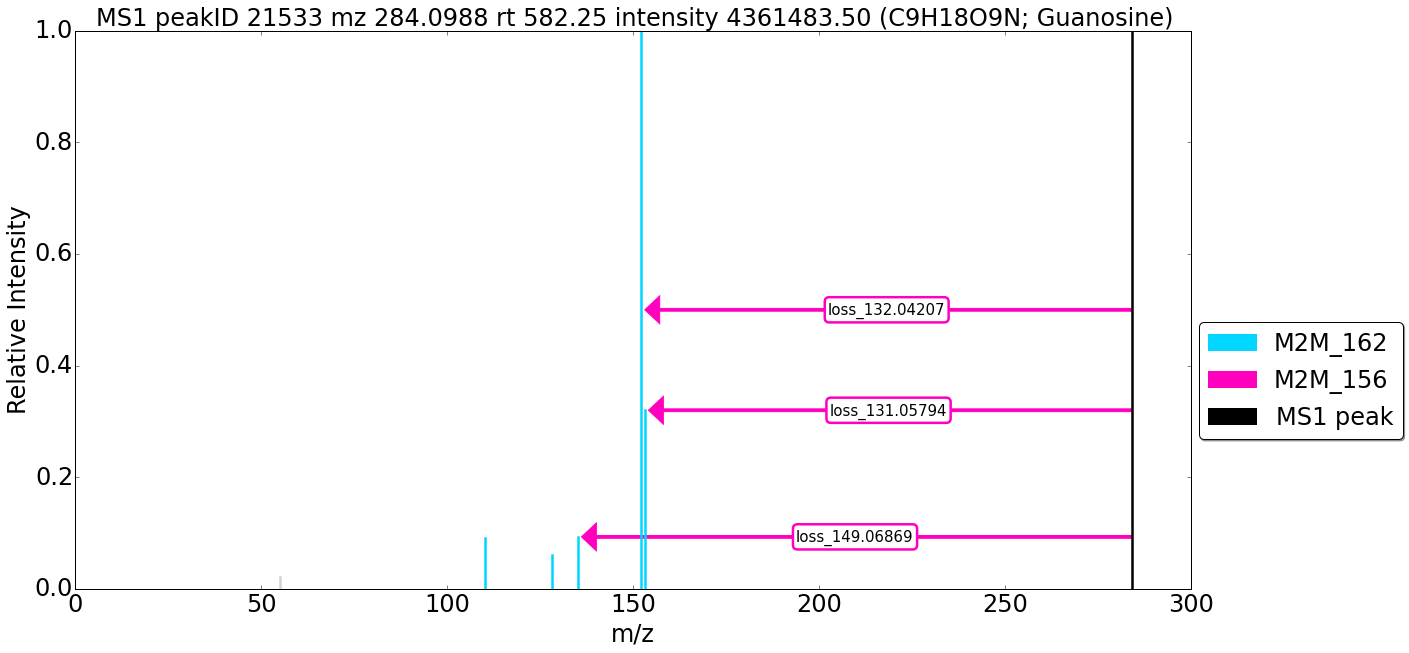

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,152.055969,1.000000,fragment_152.05609,162,loss_132.04207,156,"C4H10O5N,loss_C5H8O4"
1,153.040634,0.319968,fragment_153.04074,162,loss_131.05794,156,"C5H13OS2,loss_C5H9O3N"
2,135.029434,0.093066,fragment_135.02953,162,loss_149.06869,156,"C5H11S2,loss_C5H11O4N"
3,110.034515,0.090369,fragment_110.03458,162,loss_174.06386,NaN,"C4H4ON3,loss_C6H10O4N2"
4,128.045425,0.060353,fragment_128.04551,162,loss_156.05307,NaN,"C4H6O2N3,loss_C6H8O3N2"
5,55.029404,0.021476,fragment_55.02948,NaN,NaN,NaN,C2H3N2


MS1 peakID 12206 mz 220.1179 rt 433.35 intensity 4474088.00 (C9H18O5N; Pantothenate)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 3808 mz 147.0764 rt 628.82 intensity 28795256.00 (C5H11O3N2; L-Glutamine)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
		  fragment_84.0442 (0.854),fragment_56.04977 (0.102),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



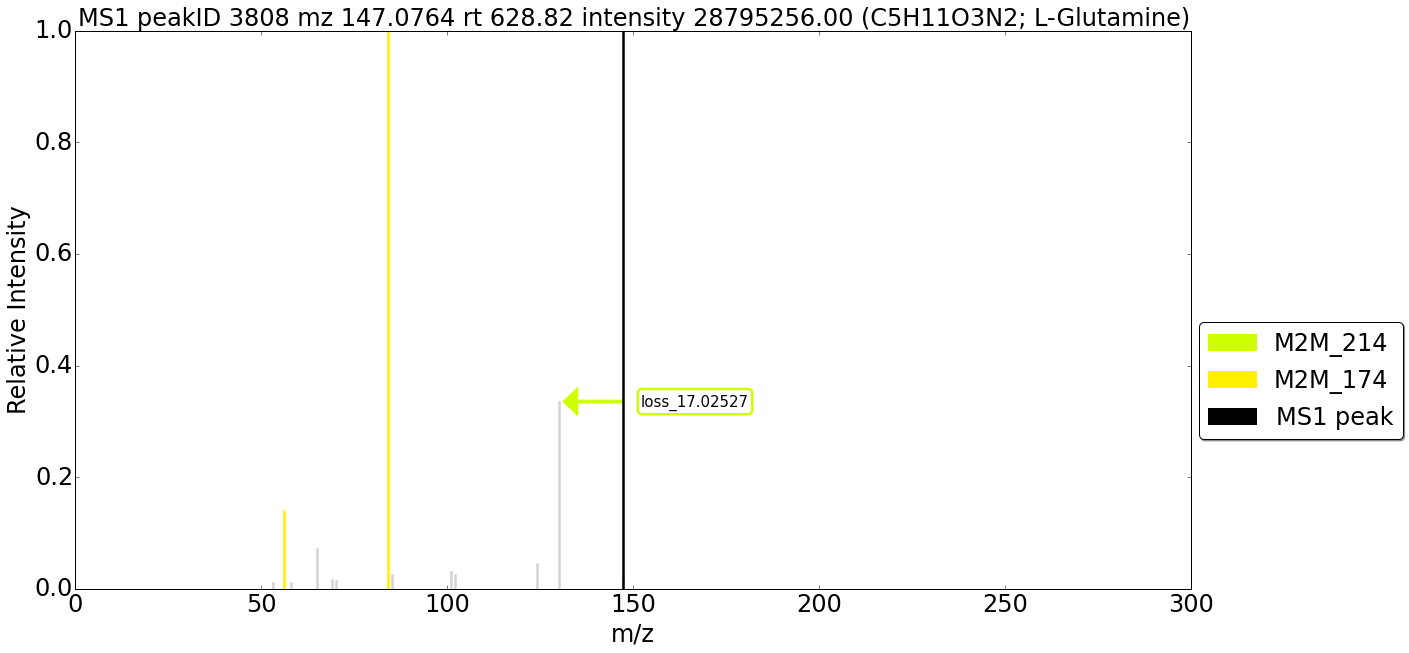

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,84.044151,1.000000,fragment_84.0442,174,loss_63.03191,NaN,"C4H6ON,loss_CH5O2N"
1,130.050446,0.335520,fragment_130.05051,NaN,loss_17.02527,214,C5H8O3N
2,56.049801,0.139607,fragment_56.04977,174,loss_91.0268,NaN,"C3H6N,loss_C2H5O3N"
3,64.927521,0.071353,fragment_64.92754,NaN,NaN,NaN,NaN
4,123.963799,0.044999,fragment_123.96388,NaN,NaN,NaN,H2ON3S2
5,101.071007,0.030830,fragment_101.07126,NaN,loss_46.00539,NaN,"C4H9ON2,loss_CH2O2"
6,85.028343,0.024785,fragment_85.02832,NaN,loss_62.04775,NaN,C4H5O2
7,102.054558,0.024073,fragment_102.0547,NaN,loss_45.02195,NaN,C4H8O2N
8,147.075653,0.016963,fragment_147.07588,NaN,NaN,NaN,C5H11O3N2
9,69.033623,0.016051,fragment_69.03368,NaN,loss_78.04263,NaN,C4H5O


MS1 peakID 2538 mz 133.0971 rt 874.87 intensity 31991762.00 (C5H13O2N2; L-Ornithine)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),
 - M2M_151	: [proline-H2O] suggests conjugated proline substructure
		  fragment_116.07116 (0.473),loss_143.05783 (0.166),loss_161.06841 (0.128),loss_115.06303 (0.101),



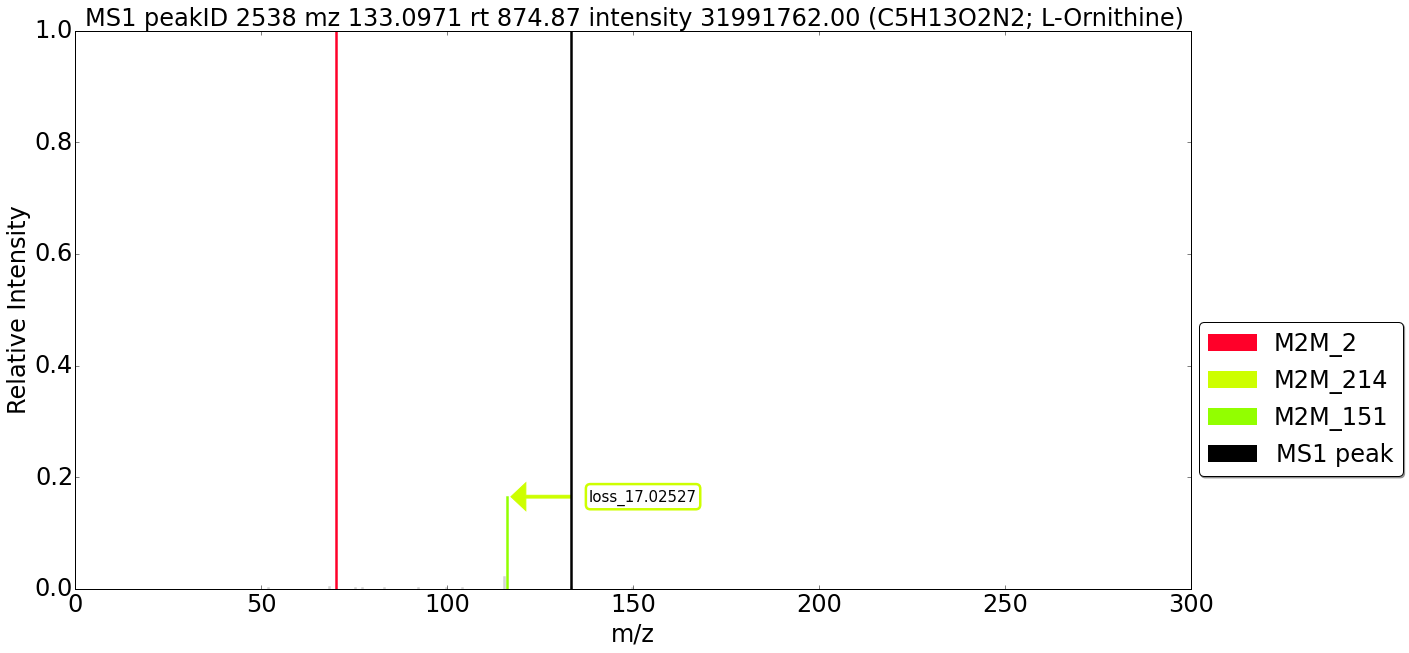

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,70.065086,1.000000,fragment_70.06514,2,loss_63.03191,NaN,"C4H8N,loss_CH5O2N"
1,116.071007,0.165084,fragment_116.07116,151,loss_17.02527,214,C5H10O2N
2,115.086891,0.021284,fragment_115.08708,NaN,loss_18.00923,NaN,C5H11ON2
3,68.049767,0.003609,fragment_68.04977,NaN,loss_65.04759,NaN,C4H6N
4,133.097900,0.003367,fragment_133.09777,NaN,NaN,NaN,C5H13O2N2
5,99.635223,0.002193,fragment_99.63522,NaN,NaN,NaN,NaN
6,92.026001,0.001910,fragment_92.02608,NaN,NaN,NaN,C2H7ONP
7,149.608582,0.001810,fragment_149.60858,NaN,NaN,NaN,NaN
8,77.039375,0.001747,fragment_77.03938,NaN,NaN,NaN,NaN
9,103.854904,0.001698,fragment_103.85492,NaN,NaN,NaN,NaN


MS1 peakID 2403 mz 132.1019 rt 519.74 intensity 28418200.00 (C6H14O2N; L-Leucine)
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



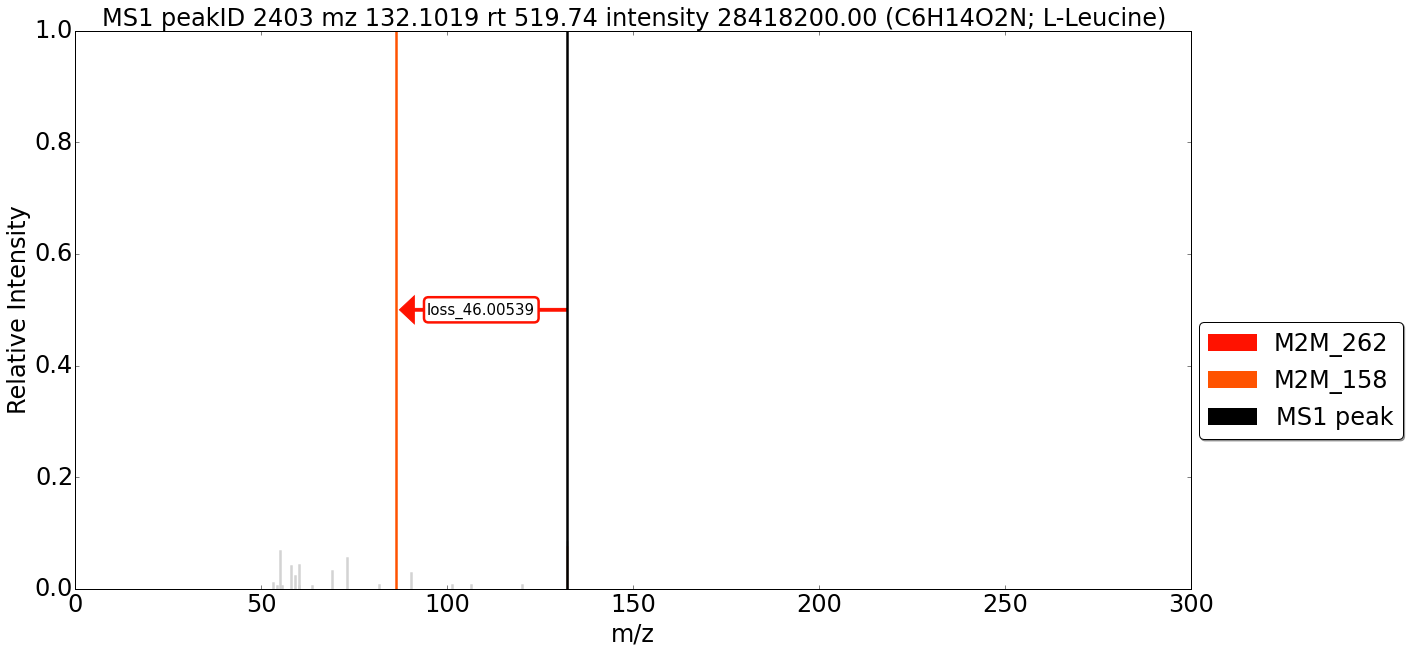

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,86.096466,1.000000,fragment_86.09652,158,loss_46.00539,262,"C5H12N,loss_CH2O2"
1,132.113068,0.084116,fragment_132.113,NaN,NaN,NaN,C5H14ON3
2,132.101547,0.074076,fragment_132.10154,158,NaN,NaN,C6H14O2N
3,55.054707,0.066982,fragment_55.05466,NaN,loss_77.04757,NaN,"C4H7,loss_C2H7O2N"
4,73.064720,0.055327,fragment_73.06466,NaN,loss_59.037,NaN,"C4H9O,loss_C2H5ON"
5,60.055786,0.042801,fragment_60.05587,NaN,loss_72.0457,NaN,CH6N3
6,58.065479,0.040572,fragment_58.06552,NaN,loss_74.0361,NaN,"C3H8N,loss_C3H6O2"
7,69.070091,0.031471,fragment_69.07013,NaN,loss_63.03191,NaN,"C5H9,loss_CH5O2N"
8,90.091843,0.028321,fragment_90.09183,NaN,loss_42.01003,NaN,NaN
9,59.073456,0.023820,fragment_59.07323,NaN,loss_73.02871,NaN,NaN


MS1 peakID 12421 mz 223.0746 rt 668.85 intensity 547783.81 (C9H20PS2; L-Cystathionine)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 19 mz 76.0393 rt 656.24 intensity 1047793.69 (C2H6O2N; Glycine)
 - M2M_184	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)
		  fragment_58.06552 (0.377),fragment_119.08937 (0.158),fragment_59.07323 (0.093),fragment_120.09034 (0.067),fragment_59.06877 (0.035),fragment_173.04168 (0.034),fragment_60.07657 (0.024),loss_59.01322 (0.021),fragment_76.07561 (0.011),



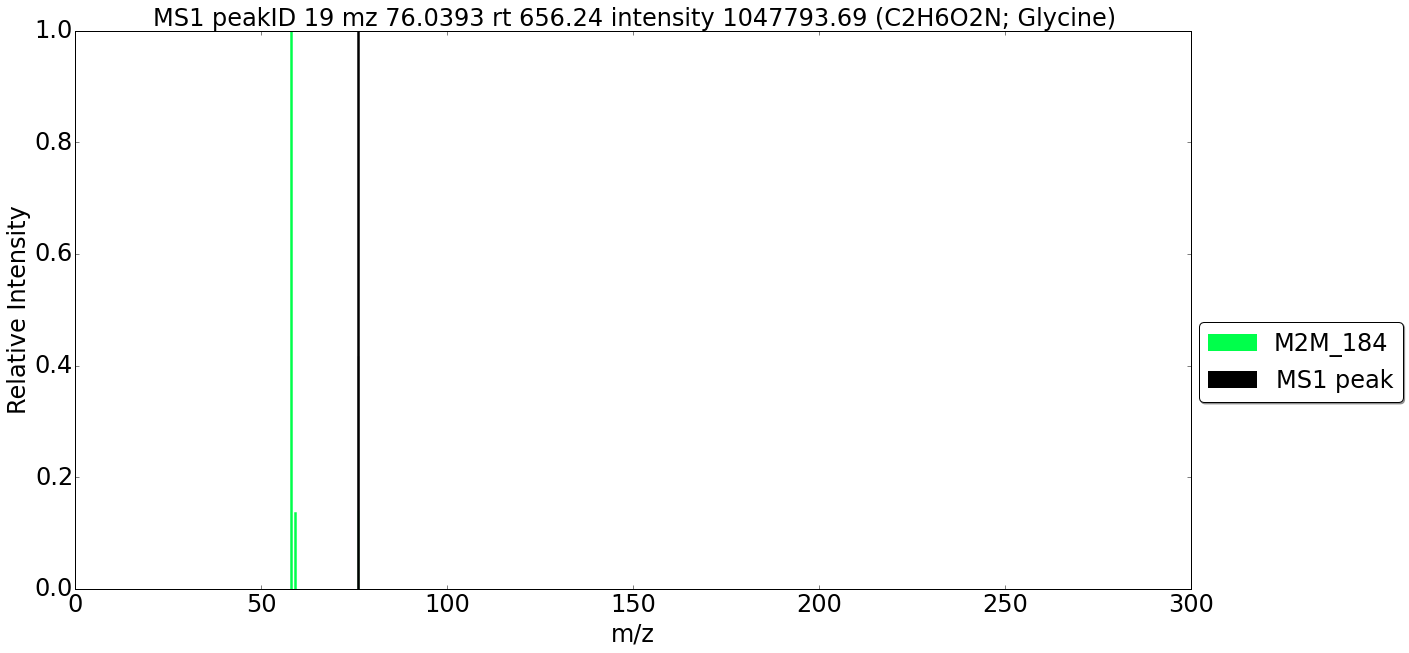

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,58.065552,1.000000,fragment_58.06552,184,loss_17.97339,NaN,C3H8N
1,76.039101,0.415062,fragment_76.03918,NaN,NaN,NaN,C2H6O2N
2,76.075615,0.138594,fragment_76.07561,184,NaN,NaN,C3H10ON
3,59.073471,0.135910,fragment_59.07323,184,NaN,NaN,NaN


MS1 peakID 4608 mz 154.0974 rt 416.80 intensity 2377199.00 (C7H12ON3; 4-(beta-Acetylaminoethyl)imidazole)
 - M2M_17	: Tyrosine substructure
		  fragment_136.07599 (0.256),fragment_182.08217 (0.092),fragment_123.04467 (0.058),fragment_165.05388 (0.050),fragment_160.90206 (0.048),fragment_119.04874 (0.042),fragment_102.0547 (0.032),fragment_95.04936 (0.026),fragment_247.1084 (0.022),fragment_161.0686 (0.019),fragment_119.04991 (0.018),fragment_165.05578 (0.017),fragment_154.08575 (0.017),loss_170.06884 (0.016),
 - M2M_91	: Aromatic substructure, i.e., benzene ring with hydroxyl and amine substitution
		  fragment_108.04425 (0.249),fragment_80.04949 (0.111),fragment_53.03888 (0.099),fragment_126.05563 (0.090),loss_55.00558 (0.051),loss_58.00534 (0.042),fragment_55.01824 (0.028),loss_41.02668 (0.026),loss_60.04021 (0.026),loss_23.01523 (0.024),fragment_75.02734 (0.023),fragment_68.01311 (0.016),loss_86.00034 (0.015),loss_40.03137 (0.014),loss_101.01104 (0.013),fragment_88.05865 (0.011),



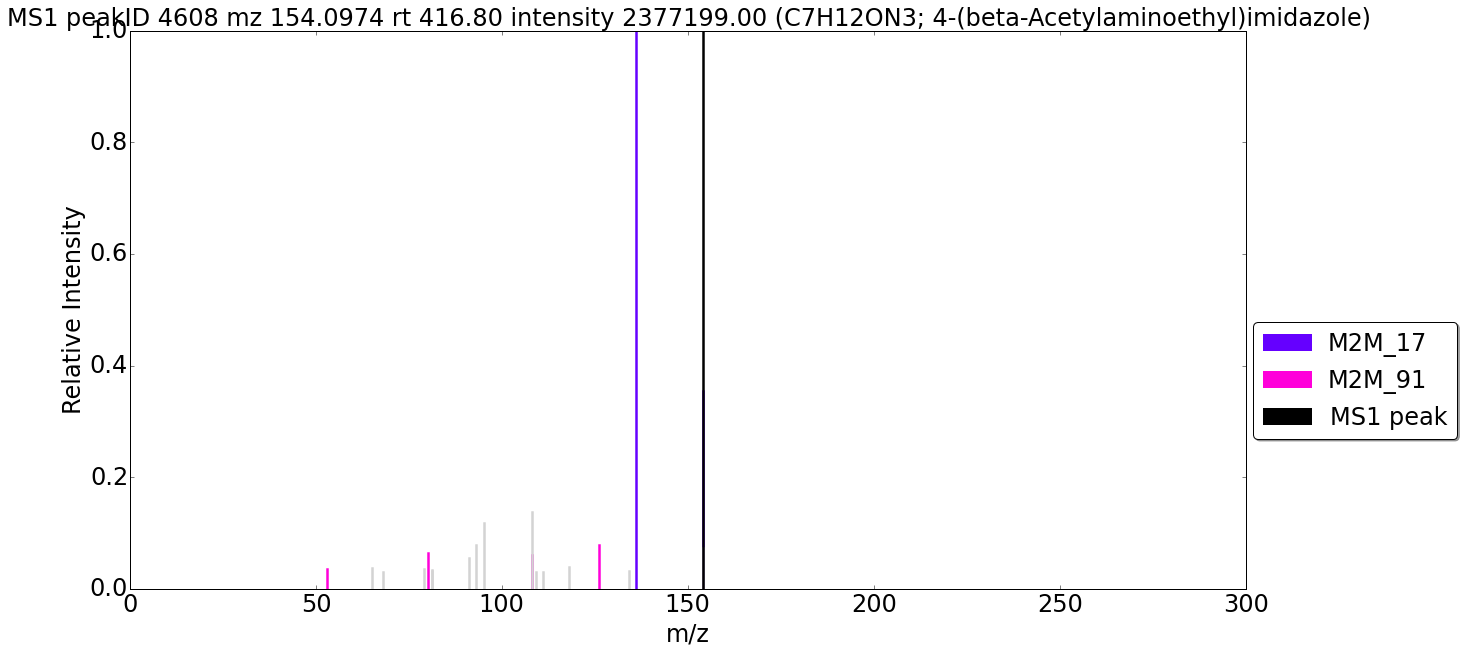

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,136.076019,1.000000,fragment_136.07599,17,NaN,NaN,C8H10ON
1,154.085831,0.355231,fragment_154.08575,17,NaN,NaN,C8H12O2N
2,108.080521,0.137766,fragment_108.08051,NaN,loss_46.01667,NaN,"C7H10N,loss_H2ON2"
3,95.060814,0.117705,fragment_95.06076,NaN,loss_59.037,NaN,"C5H7N2,loss_C2H5ON"
4,93.057152,0.079216,fragment_93.05717,NaN,NaN,NaN,C2H10N2P
5,126.055809,0.078980,fragment_126.05563,91,NaN,NaN,NaN
6,154.049515,0.072335,fragment_154.04951,NaN,NaN,NaN,C7H8O3N
7,80.049583,0.063680,fragment_80.04949,91,loss_74.04767,NaN,"C5H6N,loss_C2H6ON2"
8,108.044281,0.060566,fragment_108.04425,91,loss_46.0529,NaN,C6H6ON
9,91.054314,0.055083,fragment_91.05413,NaN,NaN,NaN,C7H7


MS1 peakID 18872 mz 268.1039 rt 469.71 intensity 8295168.00 (C9H18O8N; Adenosine)
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose
		  loss_132.04207 (0.683),loss_160.03691 (0.038),loss_149.06869 (0.037),fragment_102.06629 (0.030),loss_131.05794 (0.018),fragment_74.07118 (0.011),



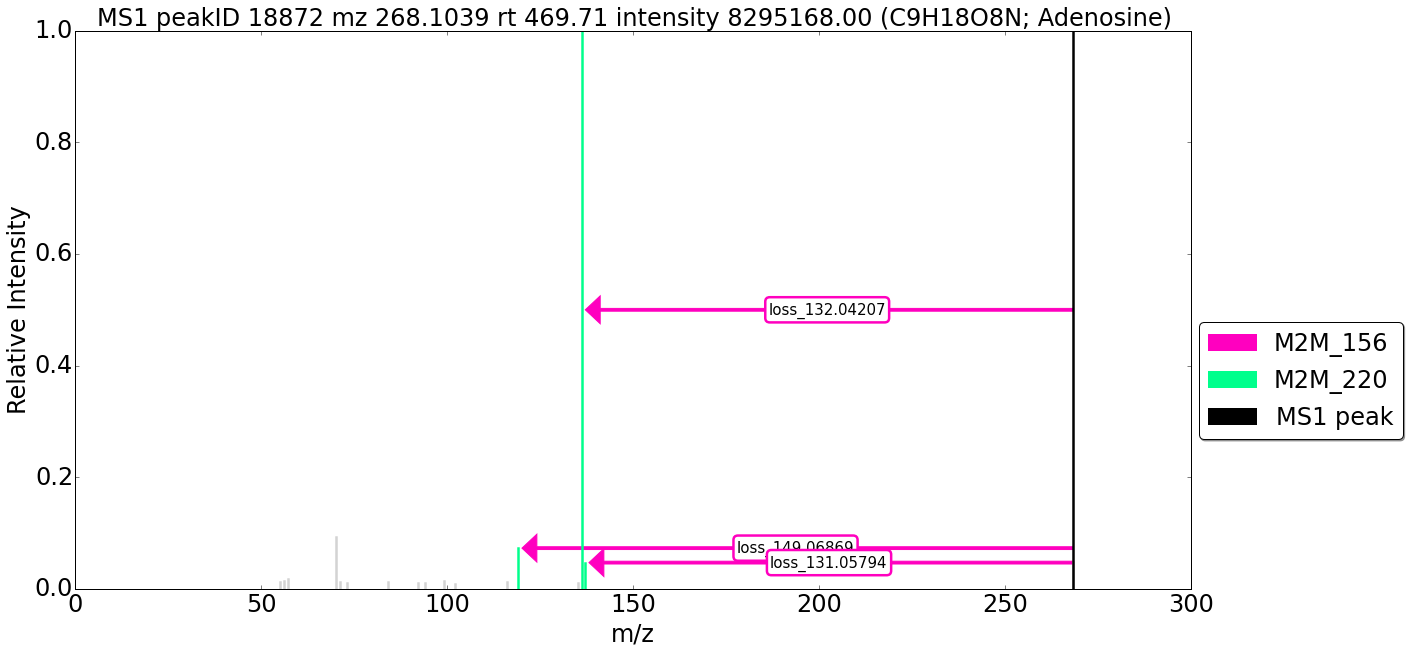

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,136.062393,1.000000,fragment_136.06239,220,loss_132.04207,156,"C5H6N5,loss_C5H8O4"
1,70.065201,0.092892,fragment_70.06514,NaN,loss_198.03757,NaN,"C4H8N,loss_C5H10O8"
2,119.035202,0.072867,fragment_119.03518,220,loss_149.06869,156,"C5H3N4,loss_C5H11O4N"
3,268.105896,0.047876,fragment_268.1059,NaN,NaN,NaN,C10H24ONP2S
4,137.046219,0.046934,fragment_137.04626,220,loss_131.05794,156,"C5H5ON4,loss_C5H9O3N"
5,57.033676,0.018227,fragment_57.0337,NaN,NaN,NaN,C3H5O
6,56.049721,0.014686,fragment_56.04977,NaN,NaN,NaN,C3H6N
7,98.983818,0.014082,fragment_98.98385,NaN,NaN,NaN,H4O4P
8,116.071213,0.012468,fragment_116.07116,NaN,loss_152.03178,NaN,"C5H10O2N,loss_C4H8O6"
9,84.044151,0.012066,fragment_84.0442,NaN,loss_184.05838,NaN,"C4H6ON,loss_C5H12O7"


MS1 peakID 141 mz 90.0550 rt 631.31 intensity 6755740.00 (C3H8O2N; L-Alanine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),



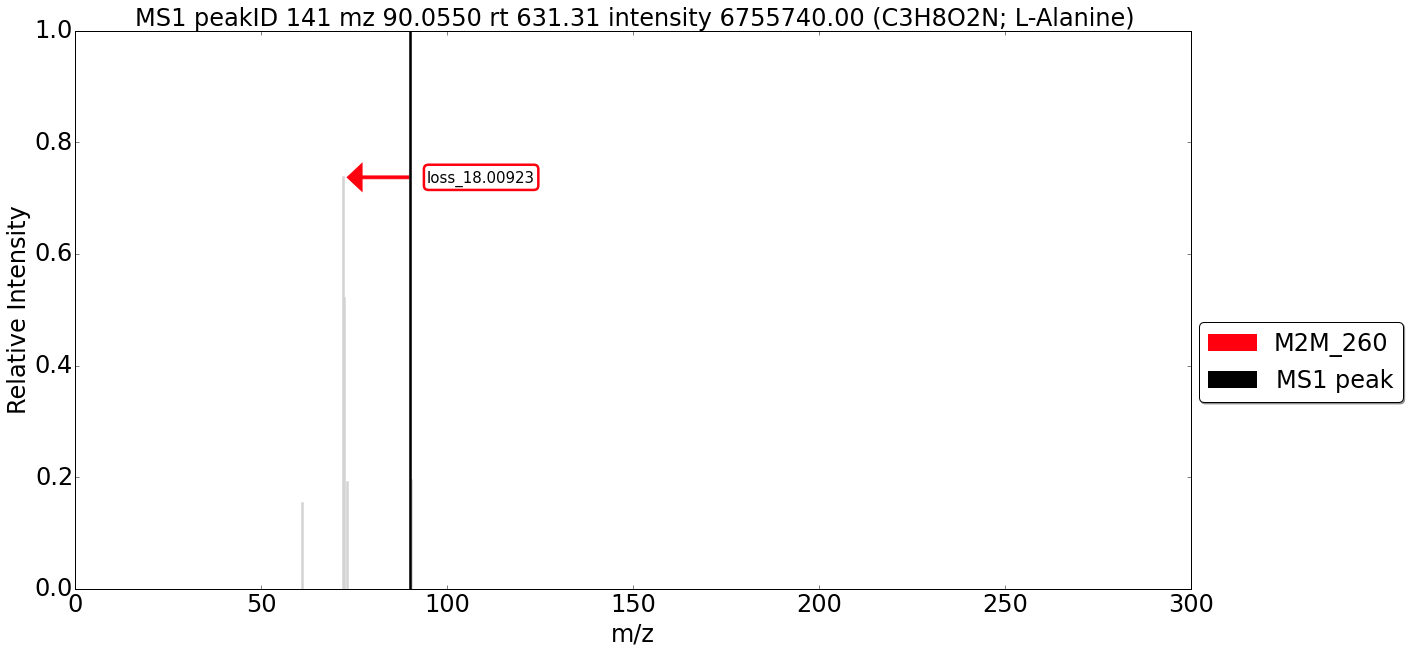

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,90.055382,1.000000,fragment_90.05533,None,NaN,NaN,C3H8O2N
1,72.044762,0.737399,fragment_72.04466,None,loss_18.00923,260,C3H6ON
2,72.080750,0.521527,fragment_72.0807,None,loss_17.97339,NaN,C4H10N
3,90.091835,0.194263,fragment_90.09183,None,NaN,NaN,NaN
4,73.084145,0.191845,fragment_73.08418,None,NaN,NaN,NaN
5,61.028442,0.153448,fragment_61.02854,None,loss_29.02613,NaN,"C2H5O2,loss_CH3N"


MS1 peakID 15724 mz 244.0928 rt 559.74 intensity 19470474.00 (C11H19ONPS; Cytidine)
 - M2M_130	: Cytosine and a loss of conjugated deoxyribose substructure
		  fragment_112.05105 (0.273),fragment_113.05456 (0.130),fragment_95.02389 (0.063),loss_133.04527 (0.037),fragment_96.02703 (0.035),fragment_113.04771 (0.026),fragment_125.03493 (0.019),fragment_69.04506 (0.016),fragment_100.03925 (0.015),fragment_191.04568 (0.015),fragment_209.05505 (0.014),loss_43.00571 (0.011),fragment_155.04439 (0.010),
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose
		  loss_132.04207 (0.683),loss_160.03691 (0.038),loss_149.06869 (0.037),fragment_102.06629 (0.030),loss_131.05794 (0.018),fragment_74.07118 (0.011),



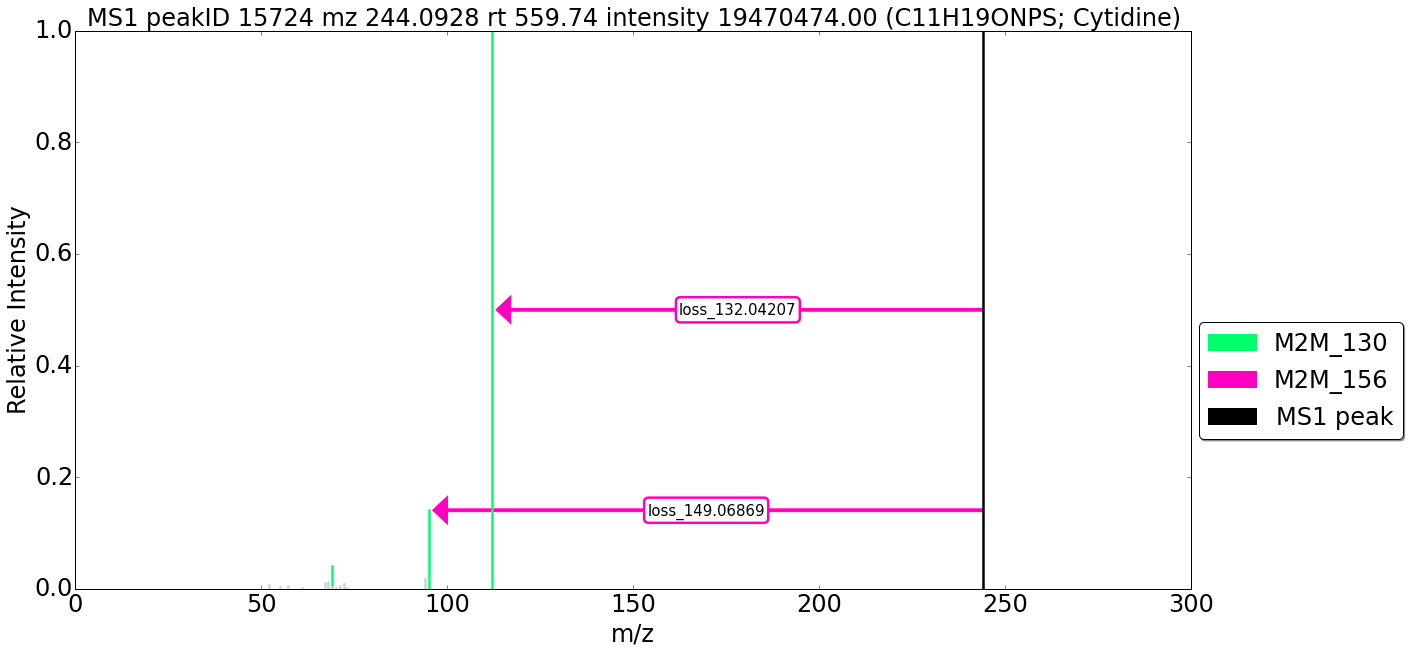

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,112.051109,1.000000,fragment_112.05105,130,loss_132.04207,156,"C4H6ON3,loss_C5H8O4"
1,95.023926,0.140786,fragment_95.02389,130,loss_149.06869,156,"C4H3ON2,loss_C5H11O4N"
2,69.045143,0.041310,fragment_69.04506,130,loss_175.04802,NaN,"C3H5N2,loss_C6H9O5N"
3,94.040627,0.017925,fragment_94.04051,NaN,loss_150.05243,NaN,loss_C5H10O5
4,68.013092,0.012192,fragment_68.01311,NaN,loss_176.07941,NaN,"C3H2ON,loss_C6H12O4N2"
5,67.029160,0.011160,fragment_67.02909,NaN,loss_177.0635,NaN,"C3H3N2,loss_C6H11O5N"
6,72.080856,0.009488,fragment_72.0807,NaN,loss_172.01297,NaN,"C4H10N,loss_C6H8N2S2"
7,52.018570,0.007214,fragment_52.01845,NaN,loss_192.07446,NaN,"C3H2N,loss_C6H12O5N2"
8,244.078018,0.005843,fragment_244.07787,NaN,NaN,NaN,C7H19O4NPS
9,57.033649,0.004293,fragment_57.0337,NaN,NaN,NaN,C3H5O


MS1 peakID 1174 mz 123.0552 rt 411.62 intensity 11639933.00 (C6H7ON2; Nicotinamide)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 288 mz 104.0705 rt 646.27 intensity 118432208.00 (C4H10O2N; 4-Aminobutanoate)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure
		  fragment_69.03368 (0.633),fragment_57.0337 (0.190),fragment_99.04377 (0.025),fragment_55.01824 (0.024),fragment_53.03888 (0.019),fragment_53.00259 (0.019),fragment_99.04454 (0.011),
 - M2M_230	: N/O-acetylation loss
		  fragment_87.04391 (0.782),fragment_187.88232 (0.031),fragment_210.89943 (0.017),



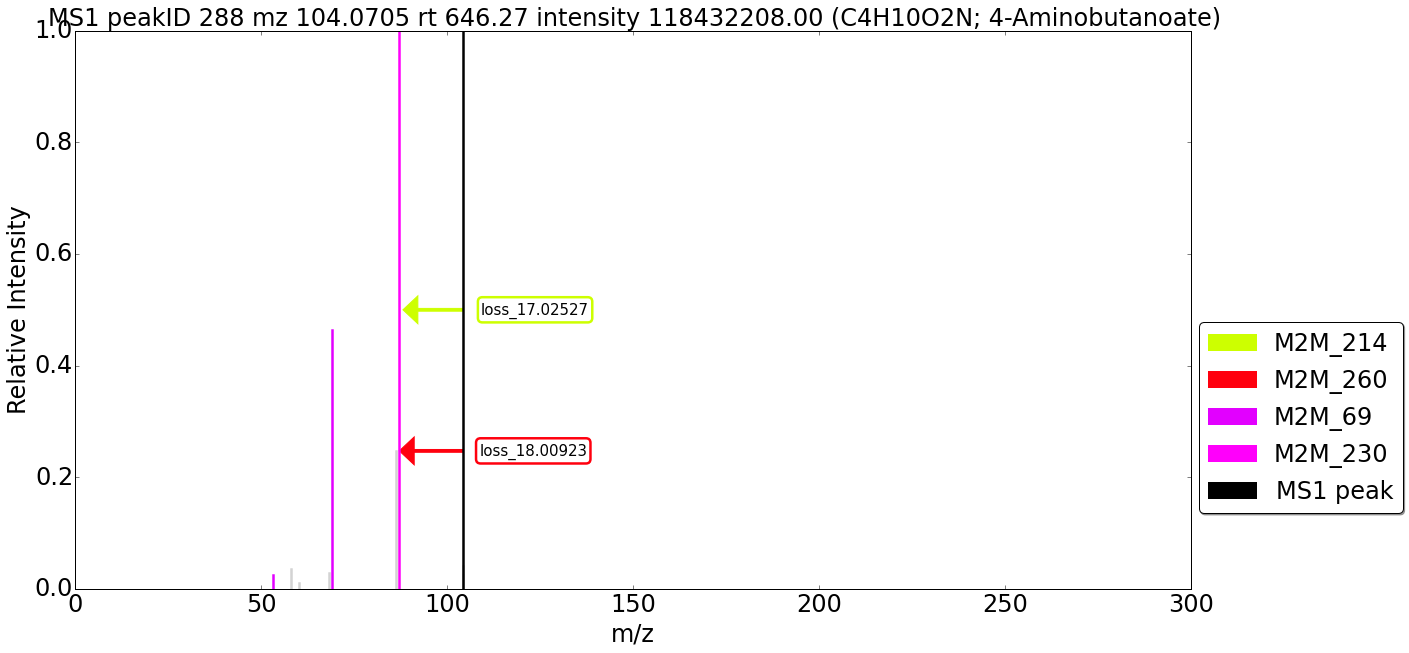

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,87.043861,1.000000,fragment_87.04391,230,loss_17.02527,214,C4H7O2
1,69.033653,0.464266,fragment_69.03368,69,loss_35.03689,NaN,C4H5O
2,86.060127,0.247173,fragment_86.06016,NaN,loss_18.00923,260,C4H8ON
3,104.071075,0.040227,fragment_104.07105,NaN,NaN,NaN,C4H10O2N
4,58.065491,0.035022,fragment_58.06552,NaN,loss_46.00539,NaN,"C3H8N,loss_CH2O2"
5,68.049789,0.028956,fragment_68.04977,NaN,loss_36.01851,NaN,C4H6N
6,53.002575,0.025035,fragment_53.00259,69,NaN,NaN,C3HO
7,104.107376,0.024224,fragment_104.10738,NaN,NaN,NaN,C5H14ON
8,60.080967,0.010841,fragment_60.08102,NaN,loss_43.98915,NaN,C3H10N


MS1 peakID 4779 mz 156.0768 rt 621.07 intensity 110043960.00 (C6H10O2N3; L-Histidine)
 - M2M_241	: Histidine substructure
		  fragment_110.07176 (0.384),fragment_83.06041 (0.112),fragment_93.04509 (0.070),fragment_156.07684 (0.049),loss_167.08599 (0.045),loss_191.06155 (0.035),fragment_363.17581 (0.023),fragment_56.04977 (0.023),loss_27.01101 (0.023),fragment_143.11757 (0.017),fragment_81.04501 (0.017),fragment_95.06076 (0.012),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



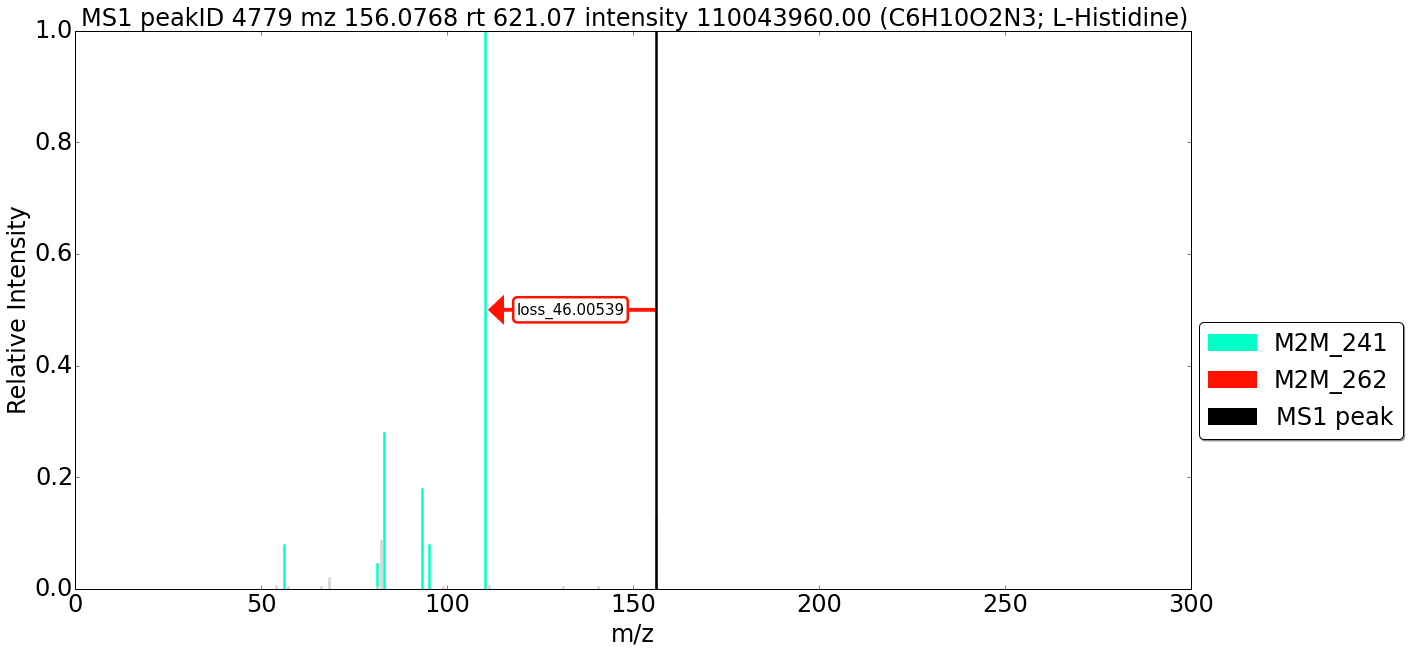

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,110.071732,1.000000,fragment_110.07176,241,loss_46.00539,262,"C5H8N3,loss_CH2O2"
1,83.060387,0.278632,fragment_83.06041,241,loss_73.01611,NaN,"C4H7N2,loss_C2H3O2N"
2,93.045082,0.179380,fragment_93.04509,241,loss_63.03191,NaN,"C5H5N2,loss_CH5O2N"
3,156.076859,0.126547,fragment_156.07684,241,NaN,NaN,C6H10O2N3
4,82.052292,0.086159,fragment_82.05232,NaN,loss_74.02423,NaN,NaN
5,56.049751,0.079081,fragment_56.04977,241,loss_100.02691,NaN,"C3H6N,loss_C3H4O2N2"
6,95.060745,0.078197,fragment_95.06076,241,loss_61.01619,NaN,"C5H7N2,loss_CH3O2N"
7,81.045174,0.043758,fragment_81.04501,241,loss_75.03184,NaN,"C4H5N2,loss_C2H5O2N"
8,68.050003,0.019948,fragment_68.04977,NaN,loss_88.02701,NaN,"C4H6N,loss_C2H4O2N2"
9,54.034096,0.005103,fragment_54.03418,NaN,loss_102.04259,NaN,"C3H4N,loss_C3H6O2N2"


MS1 peakID 789 mz 116.0705 rt 577.27 intensity 2079356160.00 (C5H10O2N; L-Proline)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



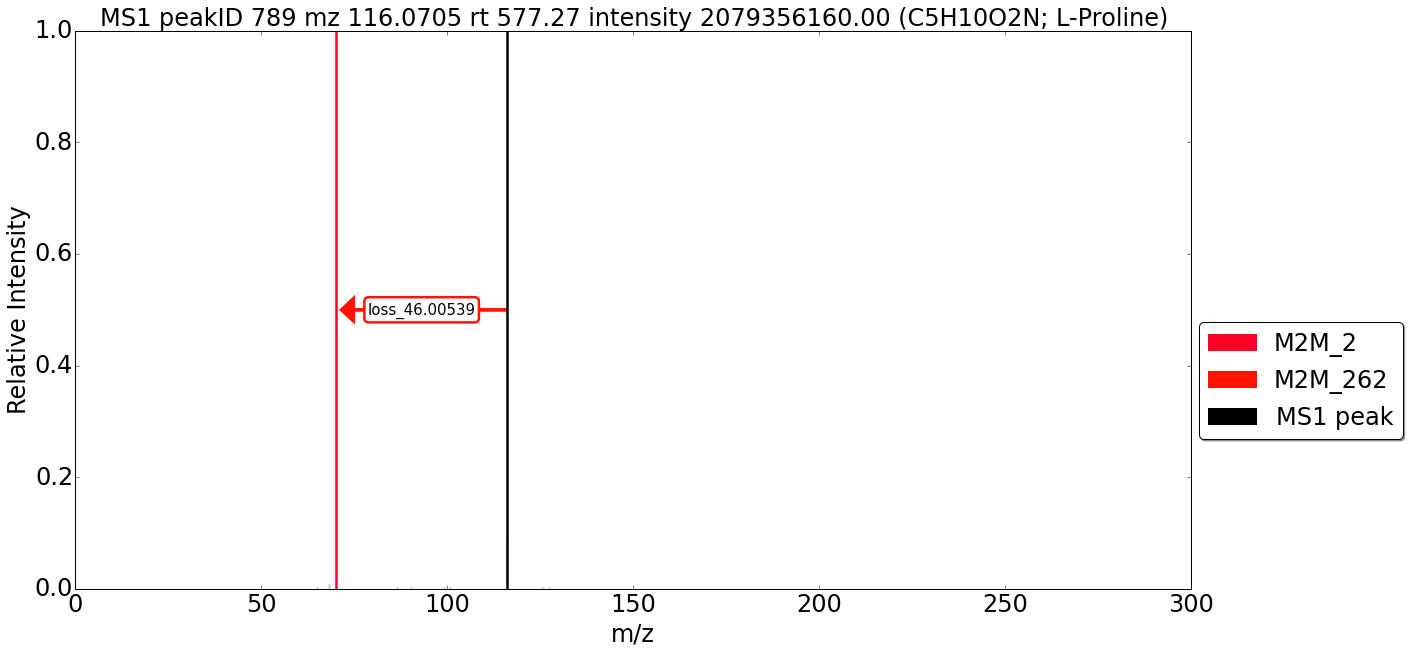

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,70.065056,1.000000,fragment_70.06514,2,loss_46.00539,262,"C4H8N,loss_CH2O2"
1,116.071083,0.086414,fragment_116.07116,NaN,NaN,NaN,C5H10O2N
2,68.049736,0.007227,fragment_68.04977,NaN,loss_48.02104,NaN,"C4H6N,loss_CH4O2"
3,99.116516,0.001514,fragment_99.11652,NaN,NaN,NaN,C7H15
4,127.208504,0.001497,fragment_127.2085,NaN,NaN,NaN,NaN
5,65.064590,0.001460,fragment_65.06459,NaN,NaN,NaN,NaN
6,86.374496,0.001367,fragment_86.3745,NaN,NaN,NaN,NaN
7,125.747429,0.001366,fragment_125.74743,NaN,NaN,NaN,NaN
8,100.580505,0.001294,fragment_100.58051,NaN,NaN,NaN,NaN
9,90.077194,0.001251,fragment_90.07719,NaN,NaN,NaN,NaN


MS1 peakID 16867 mz 252.1089 rt 439.65 intensity 29635886.00 (C9H18O7N; Deoxyadenosine)
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),



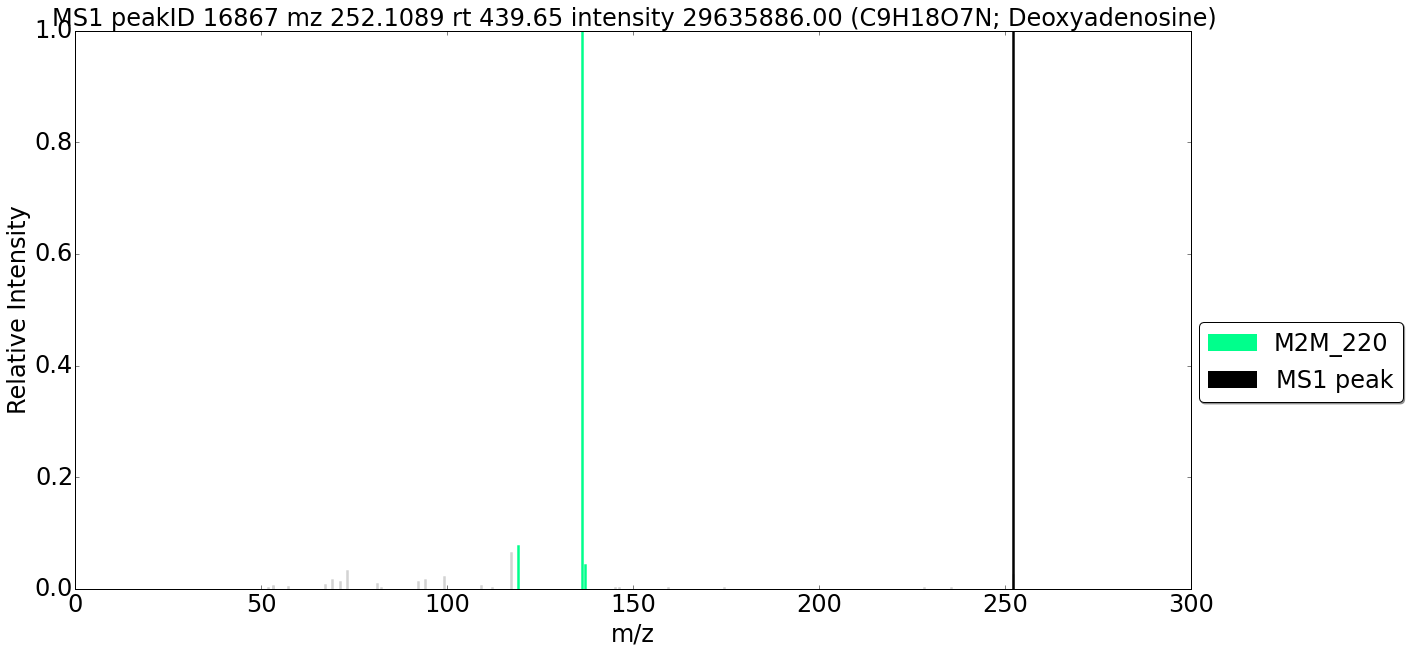

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,136.062378,1.000000,fragment_136.06239,220,loss_116.04688,NaN,"C5H6N5,loss_C5H8O3"
1,119.035149,0.075950,fragment_119.03518,220,loss_133.07377,NaN,"C5H3N4,loss_C5H11O3N"
2,117.054764,0.063908,fragment_117.05474,NaN,loss_135.05329,NaN,"C5H9O3,loss_C4H9O4N"
3,137.046112,0.041919,fragment_137.04626,220,loss_115.06303,NaN,"C5H5ON4,loss_C5H9O2N"
4,73.028610,0.031527,fragment_73.0285,NaN,loss_179.07913,NaN,"C3H5O2,loss_C6H13O5N"
5,252.108231,0.024609,fragment_252.10822,NaN,NaN,NaN,C9H18O7N
6,99.044510,0.021386,fragment_99.04454,NaN,loss_153.06453,NaN,"C5H7O2,loss_C5H7ON5"
7,94.039787,0.016530,fragment_94.0397,NaN,loss_158.06888,NaN,"C4H4N3,loss_C6H10O3N2"
8,69.033722,0.014957,fragment_69.03368,NaN,loss_183.07436,NaN,"C4H5O,loss_C5H13O6N"
9,92.024345,0.012437,fragment_92.02437,NaN,loss_160.08466,NaN,"C4H2N3,loss_C6H12O3N2"


MS1 peakID 7113 mz 176.1030 rt 653.76 intensity 48279332.00 (C6H14O3N3; L-Citrulline)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
		  fragment_70.06514 (0.979),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



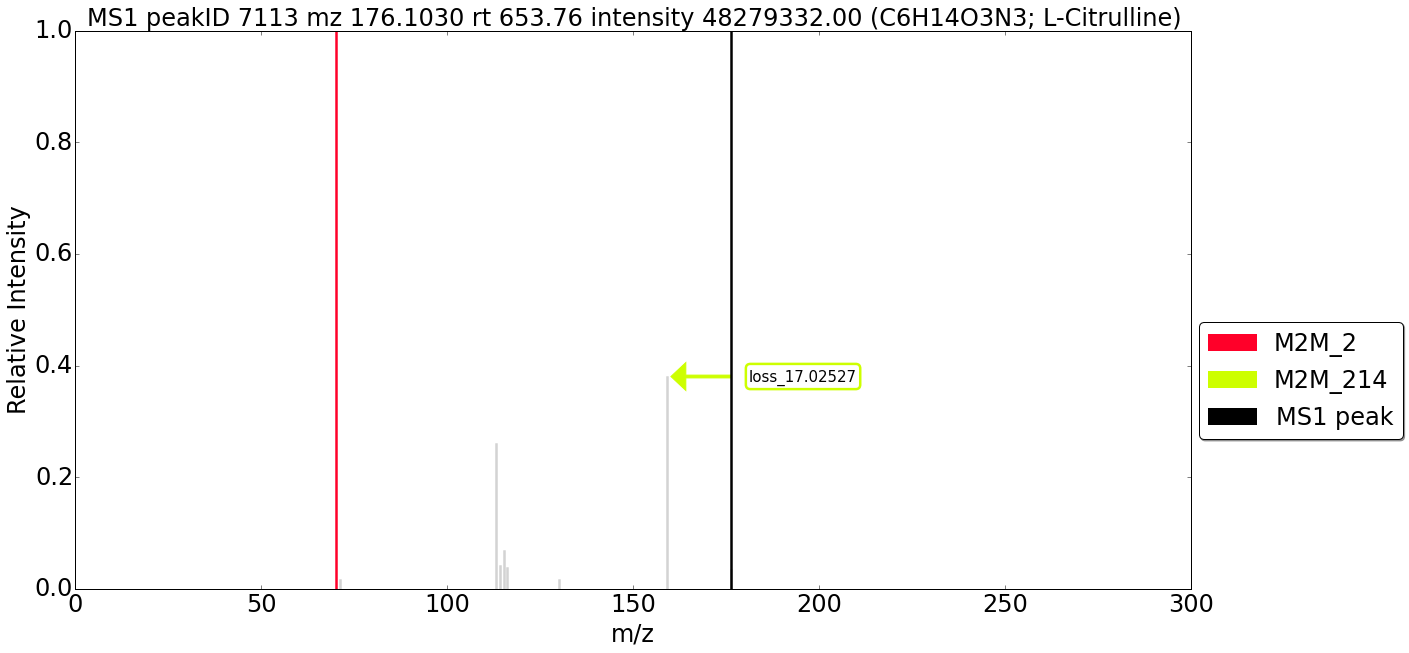

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,70.065125,1.000000,fragment_70.06514,2,loss_106.0375,NaN,"C4H8N,loss_C2H6O3N2"
1,159.076447,0.380443,fragment_159.07679,NaN,loss_17.02527,214,C6H11O3N2
2,113.071541,0.258718,fragment_113.07163,NaN,loss_63.03191,NaN,loss_CH5O2N
3,115.086868,0.068275,fragment_115.08708,NaN,loss_61.01619,NaN,"C5H11ON2,loss_CH3O2N"
4,114.055519,0.040630,fragment_114.0554,NaN,loss_62.04775,NaN,C5H8O2N
5,116.070900,0.037977,fragment_116.07116,NaN,loss_60.03217,NaN,"C5H10O2N,loss_CH4ON2"
6,176.104034,0.032875,fragment_176.10403,NaN,NaN,NaN,NaN
7,71.049393,0.016317,fragment_71.04937,NaN,loss_105.0541,NaN,"C4H7O,loss_C2H7O2N3"
8,130.064651,0.015444,fragment_130.06468,NaN,NaN,NaN,C9H8N


MS1 peakID 23395 mz 298.0968 rt 386.31 intensity 2876561.75 (C10H20O7NS; 5'-Methylthioadenosine)
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),



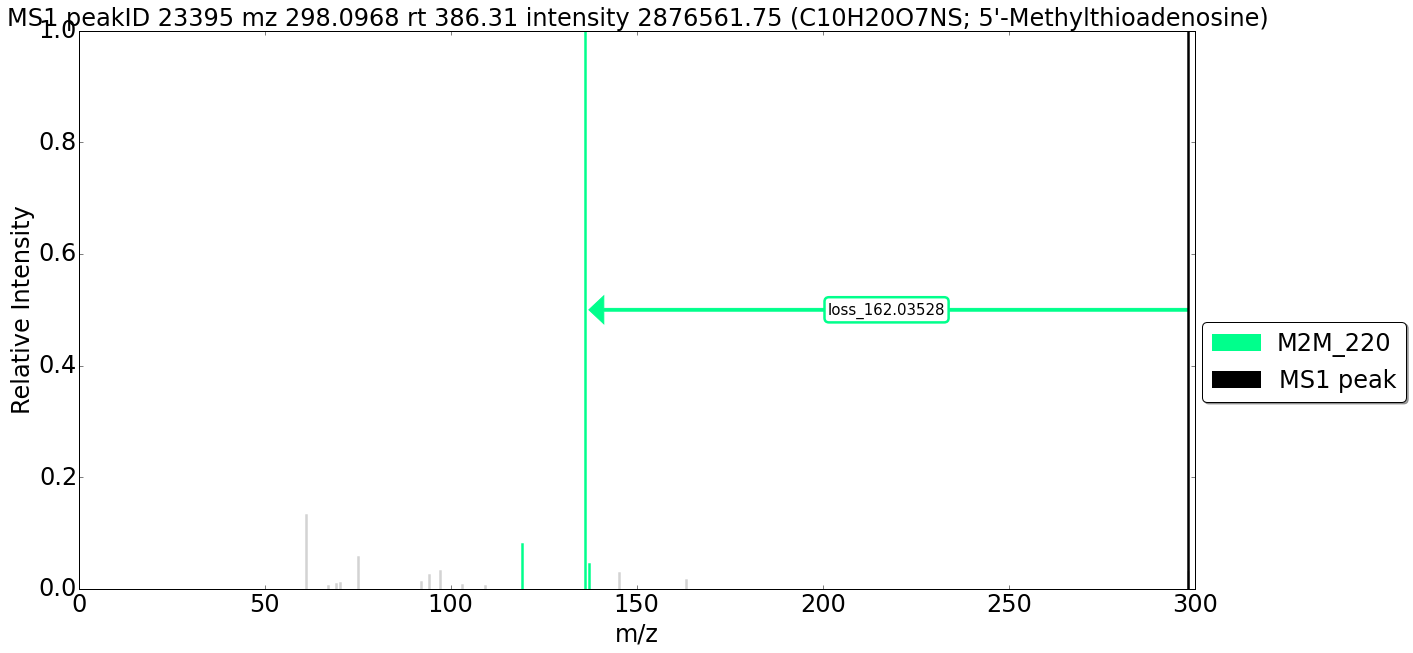

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,136.062317,1.000000,fragment_136.06239,220,loss_162.03528,220,"C5H6N5,loss_C6H10O3S"
1,61.010880,0.131672,fragment_61.01086,NaN,NaN,NaN,C2H5S
2,119.035110,0.080766,fragment_119.03518,220,NaN,NaN,C5H3N4
3,75.026161,0.057556,fragment_75.02618,NaN,NaN,NaN,C3H7S
4,137.046158,0.043943,fragment_137.04626,220,loss_161.05123,NaN,"C5H5ON4,loss_C6H11O2NS"
5,97.028412,0.031748,fragment_97.02839,NaN,NaN,NaN,C5H5O2
6,298.097382,0.030194,fragment_298.09748,NaN,NaN,NaN,NaN
7,145.031860,0.028060,fragment_145.03186,NaN,loss_153.06453,NaN,"C6H9O2S,loss_C5H7ON5"
8,94.040466,0.023968,fragment_94.04051,NaN,NaN,NaN,NaN
9,163.043198,0.016440,fragment_163.04295,NaN,loss_135.05329,NaN,"C6H11O3S,loss_C4H9O4N"


MS1 peakID 932 mz 118.0862 rt 531.06 intensity 1698129920.00 (C5H12O2N; Betaine)
 - M2M_280	: Loss possibly indicative of carboxylic acid group with 1-carbon attached
		  loss_60.02094 (0.741),loss_106.02643 (0.053),fragment_158.11806 (0.052),
 - M2M_184	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)
		  fragment_58.06552 (0.377),fragment_119.08937 (0.158),fragment_59.07323 (0.093),fragment_120.09034 (0.067),fragment_59.06877 (0.035),fragment_173.04168 (0.034),fragment_60.07657 (0.024),loss_59.01322 (0.021),fragment_76.07561 (0.011),
 - M2M_79	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)
		  fragment_118.08614 (0.371),loss_117.07884 (0.309),fragment_132.113 (0.034),loss_130.12154 (0.033),fragment_58.06552 (0.029),fragment_59.07323 (0.023),loss_177.09988 (0.010),



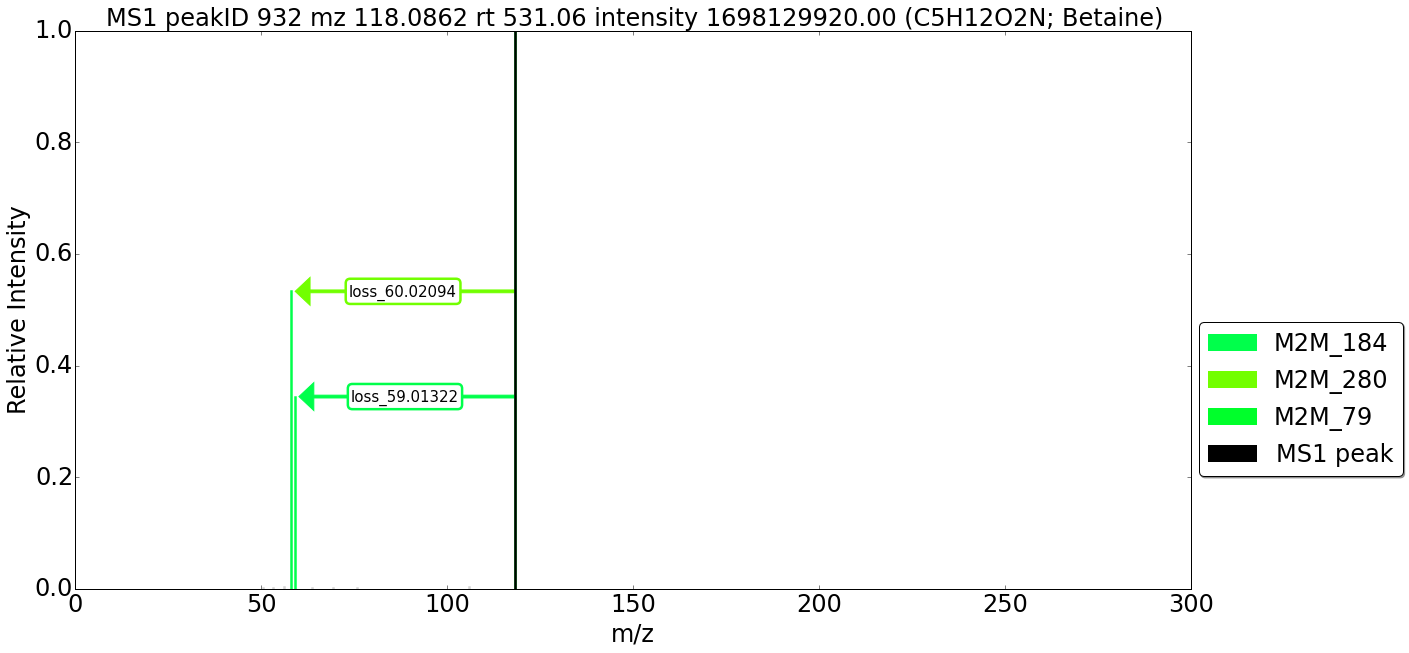

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,118.086075,1.000000,fragment_118.08614,79,NaN,NaN,C5H12O2N
1,58.065453,0.533076,fragment_58.06552,184,loss_60.02094,280,"C3H8N,loss_C2H4O2"
2,59.073425,0.344497,fragment_59.07323,184,loss_59.01322,184,NaN
3,56.049706,0.002745,fragment_56.04977,NaN,loss_62.03678,NaN,"C3H6N,loss_C2H6O2"
4,105.672386,0.002504,fragment_105.67239,NaN,NaN,NaN,NaN
5,50.379623,0.002187,fragment_50.37962,NaN,NaN,NaN,NaN
6,75.759377,0.002157,fragment_75.75938,NaN,NaN,NaN,NaN
7,69.299873,0.002068,fragment_69.29987,NaN,NaN,NaN,NaN
8,63.553288,0.002061,fragment_63.55329,NaN,NaN,NaN,NaN
9,53.141178,0.002046,fragment_53.14118,NaN,NaN,NaN,NaN


MS1 peakID 567 mz 112.0506 rt 550.96 intensity 19761036.00 (C4H6ON3; cytosine)
 - M2M_130	: Cytosine and a loss of conjugated deoxyribose substructure
		  fragment_112.05105 (0.273),fragment_113.05456 (0.130),fragment_95.02389 (0.063),loss_133.04527 (0.037),fragment_96.02703 (0.035),fragment_113.04771 (0.026),fragment_125.03493 (0.019),fragment_69.04506 (0.016),fragment_100.03925 (0.015),fragment_191.04568 (0.015),fragment_209.05505 (0.014),loss_43.00571 (0.011),fragment_155.04439 (0.010),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



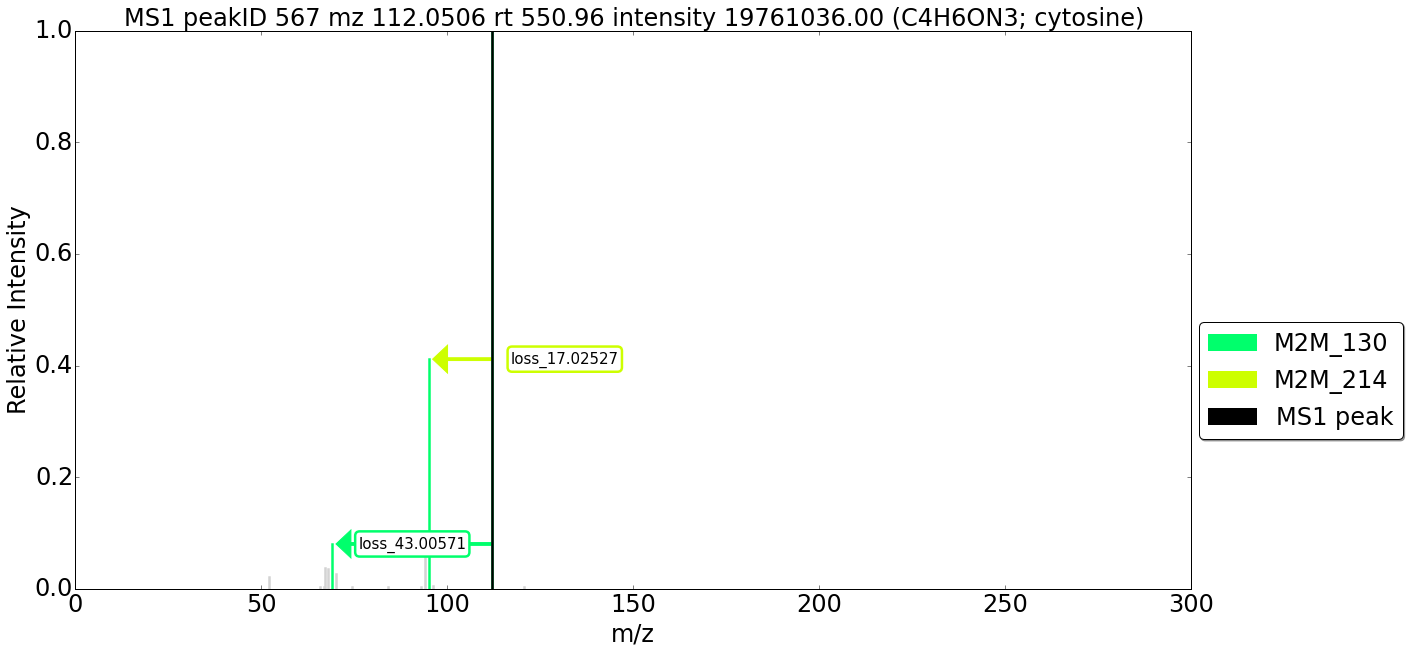

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,112.051025,1.000000,fragment_112.05105,130,NaN,NaN,C4H6ON3
1,95.023857,0.411566,fragment_95.02389,130,loss_17.02527,214,C4H3ON2
2,69.045113,0.080341,fragment_69.04506,130,loss_43.00571,130,"C3H5N2,loss_CHON"
3,94.040474,0.057541,fragment_94.04051,NaN,loss_18.00923,NaN,NaN
4,67.029007,0.036702,fragment_67.02909,NaN,loss_45.02125,NaN,"C3H3N2,loss_CH3ON"
5,68.013206,0.035020,fragment_68.01311,NaN,loss_44.03726,NaN,"C3H2ON,loss_CH4N2"
6,70.065216,0.026914,fragment_70.06514,NaN,NaN,NaN,C4H8N
7,52.018456,0.021055,fragment_52.01845,NaN,loss_60.03217,NaN,"C3H2N,loss_CH4ON2"
8,96.044106,0.004587,fragment_96.04413,NaN,NaN,NaN,C5H6ON
9,74.342247,0.003043,fragment_74.34225,NaN,NaN,NaN,NaN


MS1 peakID 12331 mz 222.0972 rt 547.24 intensity 3724312.00 (C8H16O6N; N-Acetyl-D-glucosamine)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 30635 mz 377.1452 rt 452.14 intensity 1369326.12 (C13H27ON6P2S; riboflavin)
 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure
		  fragment_69.03368 (0.633),fragment_57.0337 (0.190),fragment_99.04377 (0.025),fragment_55.01824 (0.024),fragment_53.03888 (0.019),fragment_53.00259 (0.019),fragment_99.04454 (0.011),



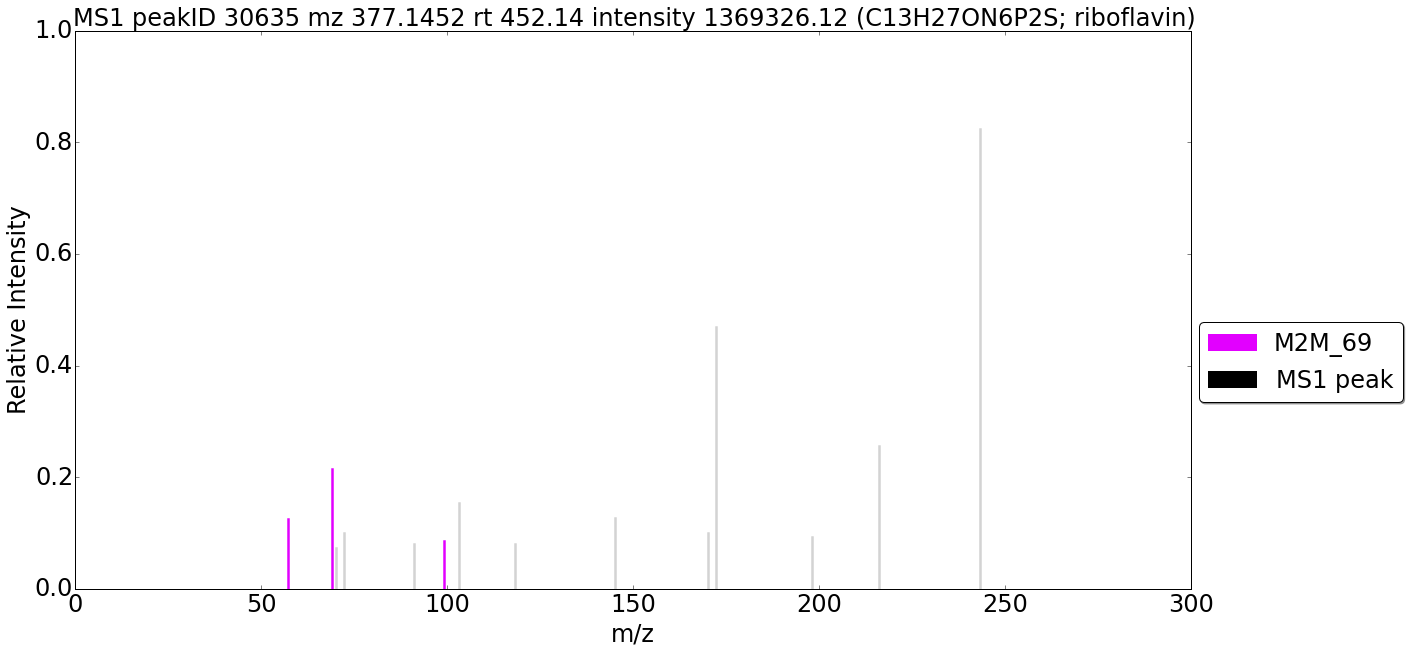

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,377.148499,1.000000,fragment_377.1485,NaN,NaN,NaN,NaN
1,243.086426,0.823206,fragment_243.08643,NaN,loss_134.05766,NaN,"C5H16O5N4P,loss_C5H10O4"
2,172.087250,0.469931,fragment_172.08712,NaN,NaN,NaN,C10H10N3
3,216.076340,0.255341,fragment_216.07642,NaN,loss_161.06841,NaN,"C3H14O4N5S,loss_C6H11O4N"
4,69.033707,0.215081,fragment_69.03368,69,NaN,NaN,C4H5O
5,103.054573,0.152992,fragment_103.05448,NaN,NaN,NaN,C8H7
6,145.076462,0.126800,fragment_145.0765,NaN,NaN,NaN,C9H9N2
7,57.033607,0.125402,fragment_57.0337,69,NaN,NaN,C3H5O
8,72.080635,0.099833,fragment_72.0807,NaN,NaN,NaN,C4H10N
9,170.070755,0.099726,fragment_170.07095,NaN,NaN,NaN,C2H12O2N5S


MS1 peakID 1414 mz 127.0501 rt 410.33 intensity 40250532.00 (C5H7O2N2; thymine)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



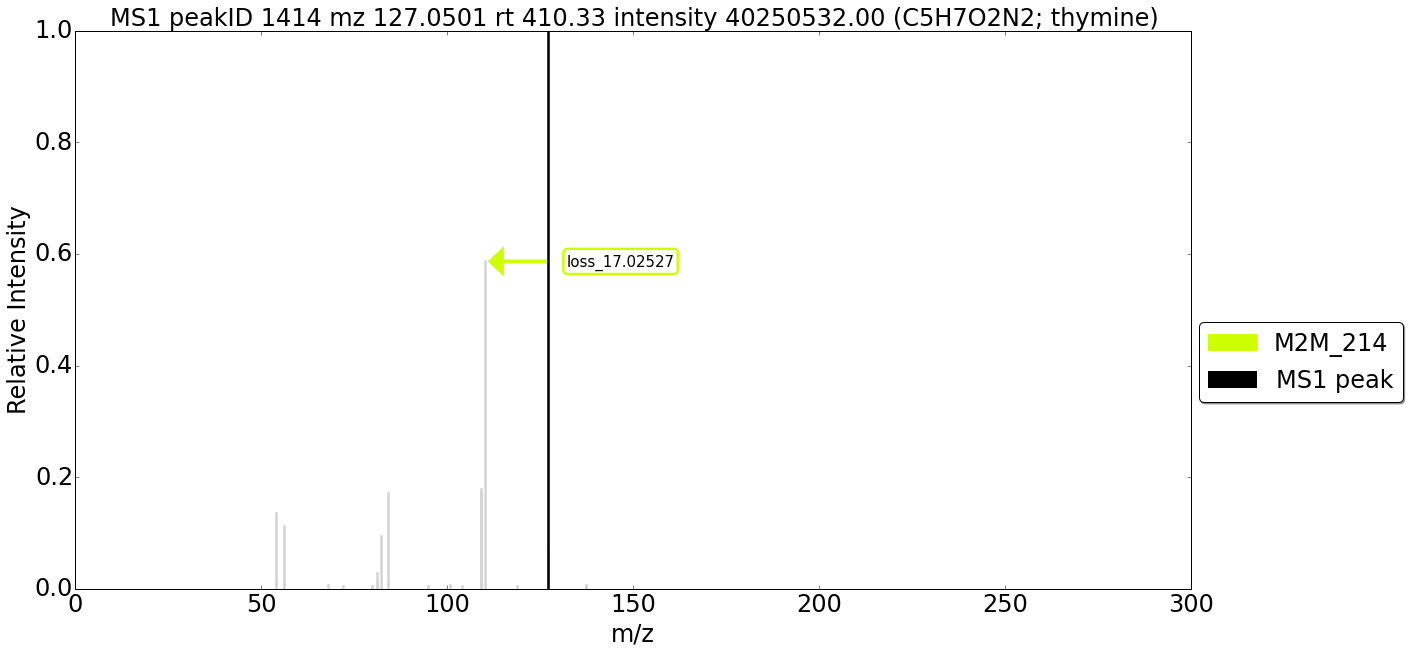

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,127.050865,1.000000,fragment_127.05087,None,NaN,NaN,NaN
1,110.023689,0.586681,fragment_110.02365,None,loss_17.02527,214,C5H4O2N
2,109.048302,0.179742,fragment_109.04827,None,NaN,NaN,NaN
3,109.039665,0.174197,fragment_109.03967,None,loss_18.00923,NaN,C5H5ON2
4,84.044159,0.171847,fragment_84.0442,None,loss_43.00571,NaN,"C4H6ON,loss_CHON"
5,54.034241,0.136419,fragment_54.03418,None,loss_73.01611,NaN,"C3H4N,loss_C2H3O2N"
6,56.049843,0.112412,fragment_56.04977,None,loss_71.00026,NaN,"C3H6N,loss_C2HO2N"
7,82.029015,0.093853,fragment_82.02903,None,loss_45.02125,NaN,"C4H4ON,loss_CH3ON"
8,127.057678,0.072781,fragment_127.05768,None,NaN,NaN,C7H11S
9,81.045082,0.028724,fragment_81.04501,None,loss_46.00539,NaN,"C4H5N2,loss_CH2O2"


MS1 peakID 2511 mz 133.0607 rt 636.29 intensity 25519770.00 (C4H9O3N2; L-Asparagine)
 - M2M_42	: Asparagine substructure
		  fragment_74.02353 (0.251),fragment_88.03919 (0.220),fragment_87.05542 (0.078),fragment_133.06148 (0.077),fragment_70.02895 (0.038),fragment_158.04483 (0.034),fragment_60.04477 (0.020),fragment_116.0344 (0.019),loss_101.04757 (0.016),fragment_175.12257 (0.015),loss_188.07979 (0.012),fragment_88.0218 (0.010),
 - M2M_211	: N-acetylputrescine substructure
		  loss_59.037 (0.567),fragment_114.09123 (0.097),loss_101.04757 (0.042),loss_59.00065 (0.030),fragment_131.11777 (0.029),fragment_425.1355 (0.029),fragment_72.04466 (0.023),fragment_60.04477 (0.014),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



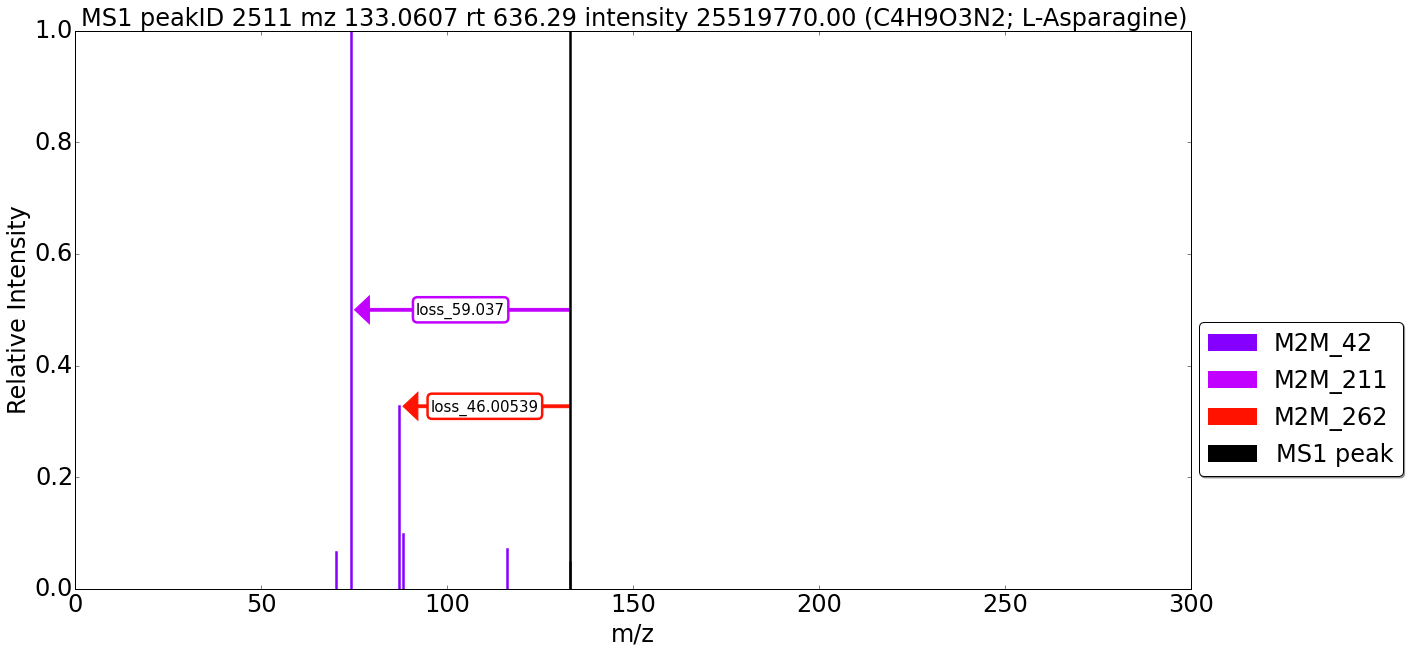

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,74.023499,1.000000,fragment_74.02353,42,loss_59.037,211,"C2H4O2N,loss_C2H5ON"
1,87.055374,0.327113,fragment_87.05542,42,loss_46.00539,262,"C3H7ON2,loss_CH2O2"
2,88.038925,0.098559,fragment_88.03919,42,loss_45.02195,NaN,C3H6O2N
3,116.034180,0.071379,fragment_116.0344,42,loss_17.02527,NaN,C4H6O3N
4,70.028931,0.066063,fragment_70.02895,42,loss_63.03191,NaN,"C3H4ON,loss_CH5O2N"
5,133.061234,0.048098,fragment_133.06148,42,NaN,NaN,NaN


MS1 peakID 2254 mz 132.0655 rt 567.29 intensity 18472026.00 (C5H10O3N; 5-Aminolevulinate)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
		  loss_18.00923 (0.942),fragment_176.09136 (0.015),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



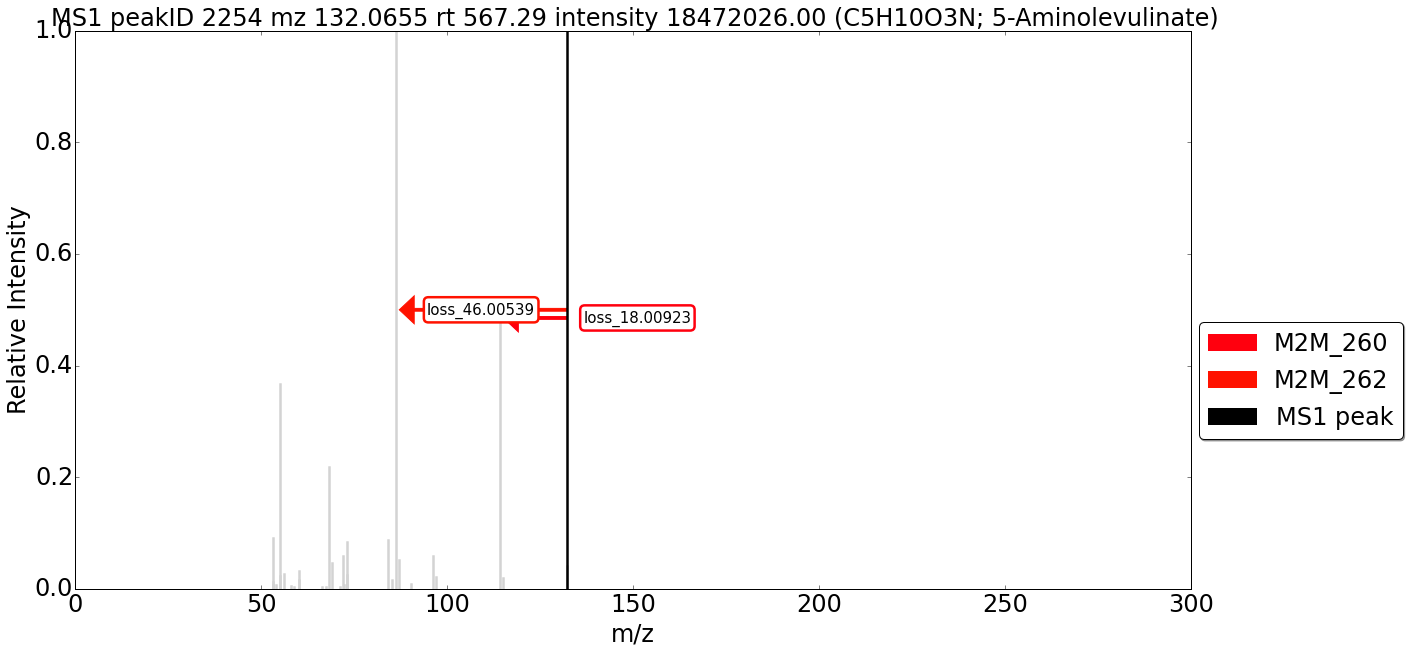

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,86.060158,1.000000,fragment_86.06016,None,loss_46.00539,262,"C4H8ON,loss_CH2O2"
1,114.055367,0.485371,fragment_114.0554,None,loss_18.00923,260,C5H8O2N
2,55.018311,0.367145,fragment_55.01824,None,loss_77.04757,NaN,"C3H3O,loss_C2H7O2N"
3,68.049873,0.218850,fragment_68.04977,None,loss_64.01595,NaN,C4H6N
4,53.038918,0.091089,fragment_53.03888,None,loss_79.02659,NaN,C4H5
5,84.080666,0.088259,fragment_84.08071,None,NaN,NaN,C5H10N
6,73.028572,0.083616,fragment_73.0285,None,loss_59.037,NaN,"C3H5O2,loss_C2H5ON"
7,72.044762,0.058873,fragment_72.04466,None,loss_60.02094,NaN,"C3H6ON,loss_C2H4O2"
8,96.044235,0.058463,fragment_96.04413,None,loss_36.01851,NaN,C5H6ON
9,87.044022,0.051343,fragment_87.04391,None,loss_45.02125,NaN,"C4H7O2,loss_CH3ON"


MS1 peakID 2632 mz 136.0618 rt 495.51 intensity 599815168.00 (C5H6N5; Adenine)
 - M2M_220	: Adenine substructure
		  fragment_136.06239 (0.688),loss_162.03528 (0.049),fragment_119.03518 (0.039),loss_153.04184 (0.027),fragment_137.04626 (0.020),
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),



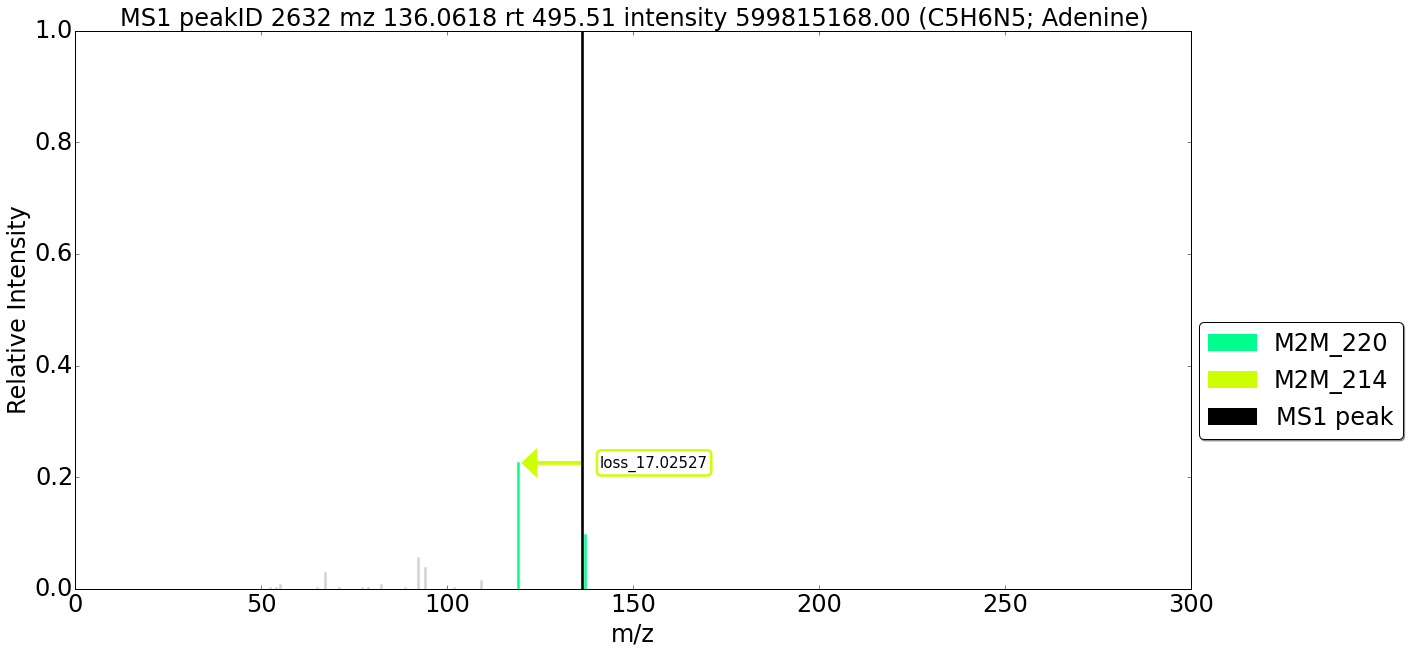

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,136.062347,1.000000,fragment_136.06239,220,NaN,NaN,C5H6N5
1,119.035172,0.225609,fragment_119.03518,220,loss_17.02527,214,C5H3N4
2,137.046173,0.096550,fragment_137.04626,220,NaN,NaN,C5H5ON4
3,92.024361,0.055838,fragment_92.02437,NaN,loss_44.03726,NaN,"C4H2N3,loss_CH4N2"
4,94.039642,0.036475,fragment_94.0397,NaN,loss_42.02193,NaN,"C4H4N3,loss_CH2N2"
5,67.029083,0.027608,fragment_67.02909,NaN,NaN,NaN,C3H3N2
6,109.050591,0.014141,fragment_109.05053,NaN,loss_27.01101,NaN,"C4H5N4,loss_CHN"
7,55.029427,0.007642,fragment_55.02948,NaN,NaN,NaN,C2H3N2
8,82.040268,0.007133,fragment_82.04025,NaN,loss_54.02177,NaN,"C3H4N3,loss_C2H2N2"
9,77.013100,0.002313,fragment_77.0131,NaN,loss_59.04824,NaN,"C4HN2,loss_CH5N3"


MS1 peakID 17496 mz 258.1099 rt 604.70 intensity 1099428992.00 (C11H20N3S2; sn-glycero-3-Phosphocholine)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 1226 mz 124.0393 rt 401.07 intensity 6944196.00 (C6H6O2N; Nicotinate)
 - No M2M for this MS1 peak at the specified thresholding levels



None

MS1 peakID 4103 mz 150.0584 rt 539.75 intensity 5108756.00 (C5H12O2NS; L-Methionine)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
		  loss_17.02527 (0.883),fragment_366.10831 (0.021),
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
		  loss_46.00539 (0.854),loss_74.0003 (0.058),loss_47.0087 (0.017),fragment_100.11239 (0.016),



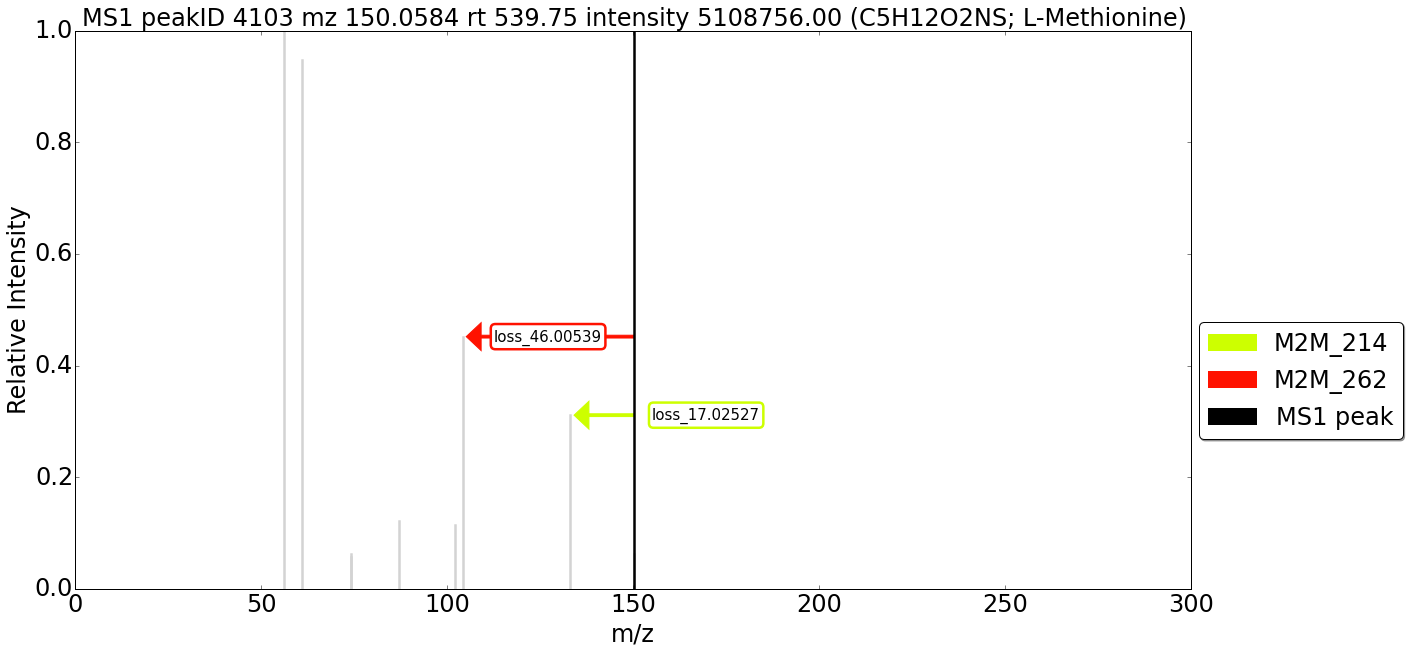

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,56.049782,1.000000,fragment_56.04977,None,NaN,NaN,C3H6N
1,61.010868,0.946880,fragment_61.01086,None,loss_89.04752,NaN,"C2H5S,loss_C3H7O2N"
2,104.052925,0.451922,fragment_104.05303,None,loss_46.00539,262,"C4H10NS,loss_CH2O2"
3,133.032288,0.311158,fragment_133.0324,None,loss_17.02527,214,C5H9O2S
4,87.026382,0.120967,fragment_87.02618,None,loss_63.03191,NaN,"C4H7S,loss_CH5O2N"
5,102.054794,0.114947,fragment_102.0547,None,NaN,NaN,C4H8O2N
6,150.057434,0.063206,fragment_150.05743,None,NaN,NaN,NaN
7,74.023499,0.063097,fragment_74.02353,None,loss_76.03519,NaN,"C2H4O2N,loss_C3H8S"
8,74.059761,0.057672,fragment_74.05984,None,NaN,NaN,C3H8ON


MS1 peakID 7901 mz 184.0733 rt 615.86 intensity 23100436.00 (C5H15O4NP; Choline phosphate)
 - M2M_243	: Conjugation of a phosphate group (H4O4P) substructure
		  fragment_98.98385 (0.736),loss_56.02612 (0.030),fragment_127.01561 (0.019),fragment_173.02023 (0.018),fragment_261.03653 (0.011),
 - M2M_158	: Leucine substructure
		  fragment_86.09652 (0.794),fragment_132.10154 (0.048),fragment_219.90121 (0.031),fragment_293.3515 (0.031),fragment_189.12428 (0.012),



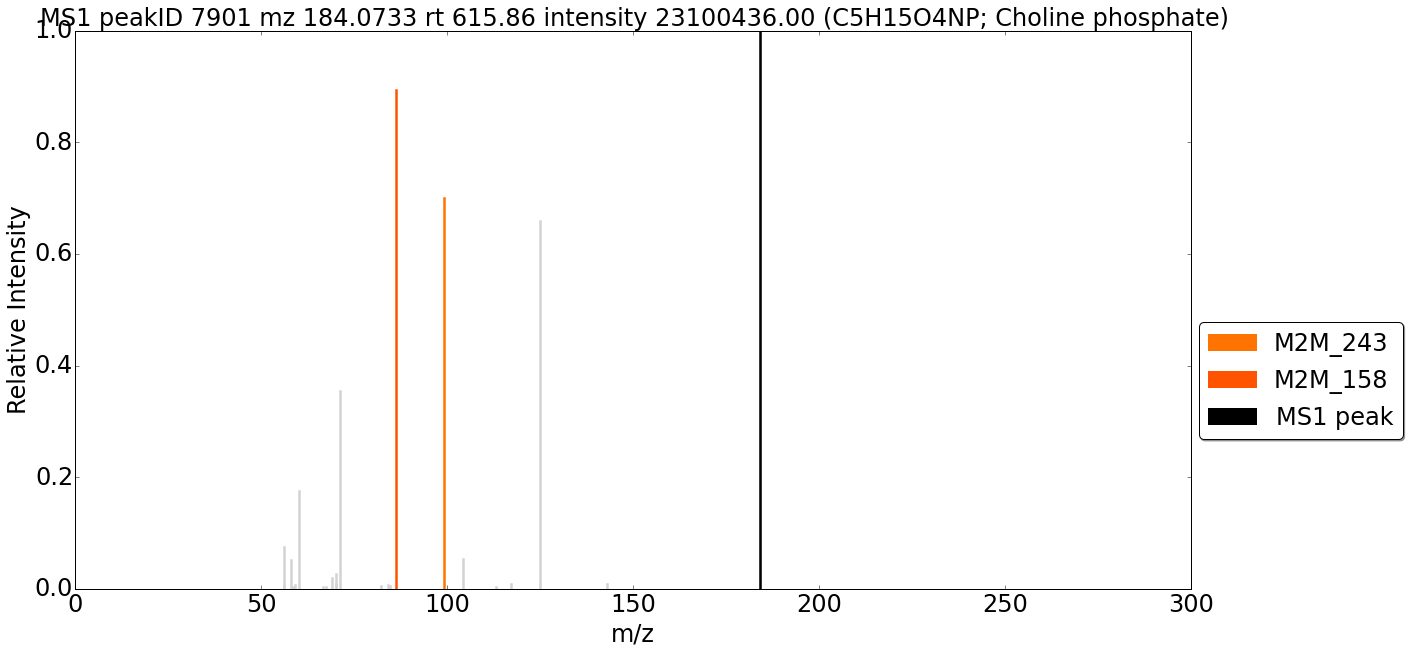

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
0,184.072342,1.000000,fragment_184.07228,NaN,NaN,NaN,C7H10O3N3
1,86.096565,0.893794,fragment_86.09652,158,NaN,NaN,C5H12N
2,98.983879,0.699893,fragment_98.98385,243,loss_85.08945,NaN,"H4O4P,loss_C5H11N"
3,124.999321,0.659842,fragment_124.99931,NaN,loss_59.07393,NaN,"C2H6O4P,loss_C3H9N"
4,71.073318,0.354179,fragment_71.07325,NaN,NaN,NaN,NaN
5,60.081051,0.175230,fragment_60.08102,NaN,NaN,NaN,C3H10N
6,56.049843,0.075443,fragment_56.04977,NaN,NaN,NaN,C3H6N
7,104.107635,0.053037,fragment_104.10738,NaN,NaN,NaN,C5H14ON
8,58.065556,0.052027,fragment_58.06552,NaN,NaN,NaN,C3H8N
9,70.036751,0.026254,fragment_70.03679,NaN,NaN,NaN,NaN


In [9]:
m2m_list = motifs_of_interest
word_map, motif_words = ms2lda.print_motif_features(quiet=True)
for i in range(len(ms1_list)):
    
    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_words, motif_colour, motif_idx, word_map, 
                      ms1_label=ms1_label, xlim_upper=300)
    display(df) # show the table to see the mz, annotations, etc